<a href="https://colab.research.google.com/github/marcomorigi95/Credit_worthiness/blob/main/Morigi_Marco_Credit_Worthiness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective and Introduction

The goal of this project is creating a model capable of estimating a customer's creditworthiness, in order to help the dedicated team deciding whether or not to accept the request for the issuance of the credit card.

We have anonymized the data available from customers who have already obtained the credit card and regularly pay their installments. We don't know the country the bank comes from, so some of our considerations are based on common sense and the structure of the dataset.

It was not specified if it is better to minimize the risk of insolvency and financial losses or to maximize profit opportunities and improve customer loyalty, and our approach to the problem can vary based on which of the two paths we decide to take. In the first case, it is better to focus on precision because we want to make sure that customers labeled as reliable are actually so. On the contrary, if we want to maximize profit opportunities and improve customer loyalty, recall may be more important to ensure that one doesn't lose reliable customers. So, trying to obtain a balance between precision and recall, measured through F1-score, will be peraphs more practical. These are only preliminary indications, then we will look into the details to search for the best solution.

# Packages

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import uniform
from scipy.stats import randint as rand

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# Exploratory data analysis
from scipy.stats import ks_2samp
# from dython import nominal
from collections import Counter

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# model interpretation
# import lime
# import lime.lime_tabular
from sklearn.tree import plot_tree

import warnings
warnings.filterwarnings("ignore")

# Custom functions

In [ ]:
def apply_converter(df, key_1, str_1, key_2, str_2, list):
    """
    Convert the "key_1" and "key_2" into "str_1" and "str_2".
    For exmaple convert the "1" and "0" into "Yes" and "No"

    Parameters
    ----------
    df: dataframe
    key_1: first value to convert
    str_1: key_1 converted into this value
    key_2: second value to convert
    str_2: key_2 converted into this value
    list: list of desired columns
    """
    mapping = {key_1: str_1, key_2: str_2}
    for i in list:
        df[i] = df[i].map(mapping)



def plot_numerical(df, col, response):
    """
    For numeric variables only and plots two graphs:
     - The first is a histogram of the column of interest and the skewness is also contained in the title.
     - In the second graph there is a boxplot of the column of interest divided by the modalities of the Response variable.

    Parameters
    ----------
    df: dataframe
    col: desired column
    response: response variable

    """

    plt.figure(figsize=(13, 5))

    # histogram
    plt.subplot(1, 2, 1)
    plt.title(f"{col} | Skewness: {round(df[col].skew(), 2)}")
    df[col].hist(grid=False, edgecolor="white", linewidth=0.7)
    plt.ylabel("Count")
    plt.xlabel(col)

    # boxplot
    plt.subplot(1, 2, 2)
    plt.title(f"{col} by Target")
    sns.boxplot(data=df, y=col, x=response, hue=response, gap=.1)
    plt.ylabel(col)
    plt.xlabel(response)





def plot_categorical(df, col, response):
    """
    For categorical variables only and plots two graphs:
     - The first is a histogram of the column count of interest.
     - In the second graph there is a histogram of the column of interest divided by the modalities of the Response variable.

    Parameters
    ----------
    df: dataframe
    col: desired column
    response: response variable
    """

    plt.figure(figsize=(14, 4))

    # histogram
    plt.subplot(1, 2, 1)
    plt.title(f"Count {col}")
    sns.countplot(data=df, x=df[col], order=df[col].value_counts().iloc[:10].index)
    plt.xticks(rotation="horizontal")
    plt.ylabel("count")

    # histogram by Response
    plt.subplot(1, 2, 2)
    plt.title(f"{col} by Target")
    sns.countplot(data=df, x=df[col], hue=response, order=df[col].value_counts().iloc[:10].index)
    plt.ylabel("count")
    plt.xticks(rotation="horizontal")




def cross_tabulation(df, x, y):
    """
    Adds percentage values in addition to absolute values to the output of the pandas crosstab function.
    For details: https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html


    Parameters
    ----------
    df: dataframe
    y: response variable
    x: desired column
    """
    print(f"Frequency table of {x} by {y}\n")

    # will normalize over each column
    tab1 = pd.crosstab(columns=df[x], index=df[y], normalize="columns")

    # calculate and print the percentage values inside the parentheses
    tab1 = ("(" + (tab1*100).round(1).astype(str) + "%)")

    tab2 = pd.crosstab(columns=df[x], index=df[y])

    # add "%" to the new percentage columns
    for i in (df[x].unique()):
        tab1 = tab1.rename(columns={i: f"{i}(%)"})

    # merge the two tables
    tab = pd.concat([tab2, tab1], axis=1, join="inner").sort_index(axis=1, ascending=True)
    print(tab)



def test_models(models, param_grid, score):
    """
    Calculates the metrics and best combination of hyperparameters for each model.
    The models will be inserted into a pipeline where preprocessing will be done and then
    the best combination of hyperparameters will be searched for through a RandomizedSearchCV.
    Finally, a fit will be carried out on the training data and the various metrics
    will be calculated on test data and then saved into a list.

    Parameters
    ----------
    models: dict of desired model
    param_grid: hyperparamter to optimize
    score: metrics to use

    Return
    ----------
    list of model's info and metrics

    """
    # Dict to store metrics for each model
    metrics = {
        "Model": [],
        "Best Parameters": [],
        "Precision": [],
        "Recall": [],
        "F1 Score": []
    }

    # Evaluate each model
    for model_name, model in models.items():

        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("Classifier", model)
        ])

        # RandomizedSearchCV definition
        random_search = RandomizedSearchCV(pipeline,
                                           param_grid[model_name],
                                           cv=5,
                                           scoring=score,
                                           random_state=0,
                                           n_jobs=-1)

        # Models fit
        random_search.fit(X_train, y_train)

        # Best paramters
        best_params = random_search.best_params_

        # Predictions
        y_pred = random_search.predict(X_test)

        # Calculation of metrics
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # list all the info and metrics
        metrics["Model"].append(model_name)
        metrics["Best Parameters"].append(best_params)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["F1 Score"].append(f1)

    return metrics



def Standard_Scaler_Converter(df, col, z):
    """
    Covert standardazied values into the original ones.

    Parameters
    ----------
    df: dataframe
    col: desired column
    z: list of standardizied values
    """
    scaler = StandardScaler()
    scaler.fit(df[[col]])

    # Mean and standard devation
    mu = scaler.mean_[0]
    sigma = scaler.scale_[0]

    for i in z:
      x = i * sigma + mu # Original value
      print(f"Standardizied {i} value| True value: {x.round(1)}")

# Dataset first exploration

Let's import the dataset:

In [ ]:
df = pd.read_csv(r"https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv ", encoding="utf-8")

In [ ]:
df.head(4)

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment    -12005.0        -4542.0   
1        Civil marriage   Rented apartment    -12005.0        -4542.0   
2               Married  House / apartment    -21474.0        -1134.0   
3  Single / not married  House / apartment    -19110.0        -3051.0   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0         1.0              1.0         0.0         0.0             NaN   
1         1.0              1.0         0.0         0.0             NaN   
2         1.0              0.0         0.0         0.0  Security staff   
3         1.0              0.0         1.0         1.0     Sales staff   

   CNT_FAM_MEMBERS  TARGET  
0              2.0       0  
1              2.0       0  
2              2.0       0  
3              1.0       1

Now let's modify the variable names to make them more understandable during the plotting of graphs and various analyses.

In [ ]:
# Dictionary for mapping column names
rename_dict = {
    "ID": "ID",
    "CODE_GENDER": "Gender",
    "FLAG_OWN_CAR": "Own_car",
    "FLAG_OWN_REALTY": "Own_realty",
    "CNT_CHILDREN": "Number_children",
    "AMT_INCOME_TOTAL": "Annual_income",
    "NAME_INCOME_TYPE": "Income_type",
    "NAME_EDUCATION_TYPE": "Education_title",
    "NAME_FAMILY_STATUS": "Family_status",
    "NAME_HOUSING_TYPE": "Housing_type",
    "DAYS_BIRTH": "Age",
    "DAYS_EMPLOYED": "Employed_days",
    "FLAG_MOBIL": "Mobile_flag",
    "FLAG_WORK_PHONE": "Work_phone_flag",
    "FLAG_PHONE": "Phone_flag",
    "FLAG_EMAIL": "Email_flag",
    "OCCUPATION_TYPE": "Occupation_type",
    "CNT_FAM_MEMBERS": "Number_family_members",
    "TARGET": "Target"
}

# Apply mapping to column names
df.rename(columns=rename_dict, inplace=True)

Let's see some info about a DataFrame, such as the index data type, columns and non-null values.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338427 entries, 0 to 338426
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     338427 non-null  int64  
 1   Gender                 338427 non-null  object 
 2   Own_car                338427 non-null  object 
 3   Own_realty             338427 non-null  object 
 4   Number_children        338427 non-null  int64  
 5   Annual_income          338427 non-null  float64
 6   Income_type            338427 non-null  object 
 7   Education_title        338427 non-null  object 
 8   Family_status          338426 non-null  object 
 9   Housing_type           338426 non-null  object 
 10  Age                    338426 non-null  float64
 11  Employed_days          338426 non-null  float64
 12  Mobile_flag            338426 non-null  float64
 13  Work_phone_flag        338426 non-null  float64
 14  Phone_flag             338426 non-nu

As we can see, we have 19 columns and 338427 entries. Let's see these entries in details:

**ID**: Discrete quantitative on a ratio scale                
**Gender**: Dichotomous (Nominal)   
**Own_car**: Dichotomous (Nominal)     
**Own_realty**: Dichotomous (Nominal)   
**Number_children**: Discrete quantitative on a ratio scale       
**Annual_income**: Continuous quantitative on a ratio scale   
**Income_type**: Nominal qualitative   
**Education_title**: Nominal qualitative  
**Family_status**: Nominal qualitative  
**Housing_type**: Nominal qualitative   
**Age**: Continuous quantitative on a ratio scale    
**Employed_days**: Continuous quantitative on a ratio scale   
**Mobile_flag**: Dichotomous (Nominal)           
**Work_phone_flag**: Dichotomous (Nominal)   
**Phone_flag**: Dichotomous (Nominal)   
**Email_flag**: Dichotomous (Nominal)   
**Occupation_type**:Nominal qualitative   
**Number_family_members**: Discrete quantitative on a ratio scale    
**Target**: Dichotomous (Nominal)  


Let's check eventual null values:

In [ ]:
print(f"Counter of NaN values per columns:\n\n{df.isnull().sum()}")

Counter of NaN values per columns:

ID                            0
Gender                        0
Own_car                       0
Own_realty                    0
Number_children               0
Annual_income                 0
Income_type                   0
Education_title               0
Family_status                 1
Housing_type                  1
Age                           1
Employed_days                 1
Mobile_flag                   1
Work_phone_flag               1
Phone_flag                    1
Email_flag                    1
Occupation_type          103342
Number_family_members         1
Target                        0
dtype: int64


At first glance, it seems that we have a lot of missing values only when it comes to **Occupation_type**. For the other variables, we have only 1 missing value per variables.
Let's see which rows have NaN values except for the variable **Occupation_type**, which we will talk more about later.

In [ ]:
columns_to_exclude = ["Occupation_type"]

# Create a new DataFrame excluding the specified columns
df_included = df.drop(columns=columns_to_exclude)

# Identify rows that contain NaN values
rows_with_nan = df.loc[df_included.isnull().any(axis=1)]
rows_with_nan

ID Gender Own_car Own_realty  Number_children  Annual_income  \
338426  6392180      F       N          N                0        67500.0   

       Income_type Education_title Family_status Housing_type  Age  \
338426     Working  Secondary / se           NaN          NaN  NaN   

        Employed_days  Mobile_flag  Work_phone_flag  Phone_flag  Email_flag  \
338426            NaN          NaN              NaN         NaN         NaN   

       Occupation_type  Number_family_members  Target  
338426             NaN                    NaN       0

The missing values ​​of the other variables correspond to a single record. Since it is just one row, and the null values ​​are too many, we opted to remove the entire row.

In [ ]:
# We exclude this column, because we will deal with it later
columns_to_check = df.columns.difference(["Occupation_type"])

# Remove the row with NaN values
df = df.dropna(subset=columns_to_check)

Let's check if the row was correctly removed.

In [ ]:
print(f"Counter of NaN values per columns:\n\n{df.isnull().sum()}")

Counter of NaN values per columns:

ID                            0
Gender                        0
Own_car                       0
Own_realty                    0
Number_children               0
Annual_income                 0
Income_type                   0
Education_title               0
Family_status                 0
Housing_type                  0
Age                           0
Employed_days                 0
Mobile_flag                   0
Work_phone_flag               0
Phone_flag                    0
Email_flag                    0
Occupation_type          103341
Number_family_members         0
Target                        0
dtype: int64


The row is correctly removed. Now we have null values only for **Occupation_type**.

## Duplicates check

Now let's check for evantual duplicates:

In [ ]:
print(f"Counter of duplicates rows: {Counter(df.duplicated())[1]}")
print(f"Counter of unique rows: {Counter(df.duplicated())[0]}")

Counter of duplicates rows: 0
Counter of unique rows: 338426


It seems that there are no duplicates. But focusing only on this can lead to hasty conclusions, because leaving the variable **ID** can hide potential duplicates.  
Thus let's remove the **ID** variable:

In [ ]:
df = df.drop("ID", axis=1)

Let's re-check for potential duplicates:

In [ ]:
print(f"Counter of duplicates rows: {Counter(df.duplicated())[1]}")
print(f"Counter of unique rows: {Counter(df.duplicated())[0]}")

Counter of duplicates rows: 263170
Counter of unique rows: 75256


Well, almost 77% of the dataset was made by duplicates! The variable **ID** only was hiding 263170 duplicate records. Now, let's remove those duplicates since they can lead us to biased analysis and the models can be overtrained on duplicate data, leading to an overconfidence in predictions and poor generalization on unseen data.

In [ ]:
df = df.drop_duplicates()

Now that we have removed all the certain duplicates, can we be satisfied?
All duplicates are removed, but sometimes there are more hidden duplicates. Let's check for example these two records:

In [ ]:
df.loc[[1464,1466]]

Gender Own_car Own_realty  Number_children  Annual_income Income_type  \
1464      F       N          Y                0       171000.0     Student   
1466      F       N          Y                0       171000.0     Student   

       Education_title Family_status       Housing_type      Age  \
1464  Higher education       Married  House / apartment -18756.0   
1466  Higher education       Married  House / apartment -18756.0   

      Employed_days  Mobile_flag  Work_phone_flag  Phone_flag  Email_flag  \
1464        -3904.0          1.0              0.0         0.0         1.0   
1466        -3904.0          1.0              0.0         0.0         1.0   

     Occupation_type  Number_family_members  Target  
1464      Core staff                    2.0       0  
1466      Core staff                    2.0       1

These two records are quite suspicious. It seems highly unlikely that two customers would have 17 out of 18 same fields being two different people. We want to eliminate these cases from our dataset as well, to try to draw more accurate and unbaised conclusions. To discover if there are more of these cases, we will drop one column at once, check for any possible duplicates and remove them.

In [ ]:
for i in df.columns:
    col_to_remove = i
    col_removed = df[col_to_remove]

    df = df.drop(columns=[col_to_remove])

    df = df.drop_duplicates()

    # re-add the removed column
    df[col_to_remove] = col_removed

Now we have a dataset without any potential duplicates.

In [ ]:
print(f"Dataframe without duplicates result in {df.shape[0]} rows")

Dataframe without duplicates result in 61918 rows


# EDA and Feature Engineering

Let's start by coverting the values of the variables for more readability.

In [ ]:
col_1_0 = ["Work_phone_flag", "Mobile_flag", "Phone_flag", "Email_flag"]
apply_converter(df, 1, "Yes", 0, "No", col_1_0)

col_Y_N = ["Own_car", "Own_realty"]
apply_converter(df, "Y", "Yes", "N", "No", col_Y_N)

apply_converter(df, "F", "Female", "M", "Male", ["Gender"])

apply_converter(df, 1, "Trustworthy", 0, "Not Trustworthy", ["Target"])

We create two sub dataframes to separate numerical and categorical variables.

In [ ]:
df_num =  df[["Annual_income", "Age", "Employed_days","Number_children","Number_family_members"]]
df_cat = df.drop(columns=(df_num))

Now we are going to analyze all the features.

## Numerical variables

Next, we have a preliminary analysis of the numerical variables to get a general idea and then delve into it in more details.

In [ ]:
df_num.describe(include="all").T.round(1)

count      mean       std      min       25%  \
Annual_income          61918.0  184122.9  106305.2  26100.0  117000.0   
Age                    61918.0  -15132.4    3867.8 -25201.0  -18047.8   
Employed_days          61918.0   22273.0   92108.0 -17531.0   -3133.0   
Number_children        61918.0       0.5       0.8      0.0       0.0   
Number_family_members  61918.0       2.2       0.9      1.0       2.0   

                            50%       75%        max  
Annual_income          157500.0  225000.0  6750000.0  
Age                    -14829.0  -11955.0    -7489.0  
Employed_days           -1590.0    -643.0   365243.0  
Number_children             0.0       1.0       19.0  
Number_family_members       2.0       3.0       20.0

**Annual_income** - It corresponds to the annual income. We have a minimum of 26'100 and a maximum of 6'750'000, and considering the 50 percentile (median) the max values seems to be a bit suspicious.

**Age** - It is calculated as the number of days that have passed since birth. The lowest value that corresponds to an older age is -25201 (about 69 years), while the highest value that corresponds to a younger age is 7489 (about 20 years). For the moment, there is nothing suspicious regarding the **Age** variable.  

**Employed_days** - It corresponds to the number of days that have passed since the hiring date. If positive, it indicates the number of days since unemployment. The minimum is -17531 days (approximately 48 years), therefore a plausible value; while as a positive value, which corresponds to the number of unemployed days, it is 365243 days (approximately 1000 years). We are definitely in the situation of input errors.  

**Number_children** - It is the number of children. We note that the majority is between 0 and 1, but as a maximum we have 19.

**Number_family_members** - It corresponds to the number of family members. We have a minimum value of 1, which is accepted (0 would have been considered incorrect), while a maximum of 20 is a somewhat suspicious value.

Now let's look at the numerical variables in more detail.

### Annual_income

As mentioned before, for the annual income there were some suspicious values, ​​but we don't know how many. Again, if we had information about the country we could have done more detailed consideration. Given that on average the median annual salary is around 157'500, to stay safe we decided to set the reference value at 1'000'000.
Let's check how many customers have more than 1 milion annual income.

In [ ]:
print(f"There are {Counter(df['Annual_income'] < 1000000)[0]} outliers values")

There are 47 outliers values


Since there aren't many outliers, assuming that they are incorrect values, we're going to replace them with the median value of annual income of less than 1'000'000.

In [ ]:
median_val = df["Annual_income"][df["Annual_income"] < 1000000].median()

df["Annual_income"] = np.where(df["Annual_income"] >= 1000000, median_val, df["Annual_income"])

Let's graphically observe the distribution of the annual salary and the boxplots by Target.

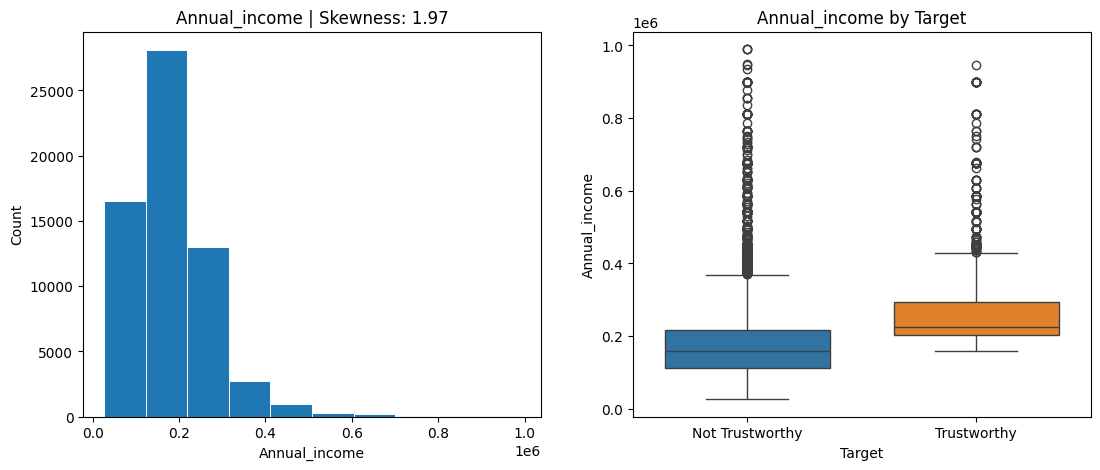

In [ ]:
plot_numerical(df, "Annual_income", "Target")

As we observe from the histogram, we have a right skewed distribution.
As for the boxplots, at first it seems a bit intuition based, with customers who come with a high income, starting from 150,000, tend to be more regular with the payment of the credit card installments.

### Age    

Since the age is represented in number of days passed since birth with the variable **Age**, we are going to change it so that it represents the years of the customers, in the following way.

In [ ]:
df["Age"] = (df["Age"]/-365).round(0)

Let's observe the age distributions graphically and the boxplots by Target:

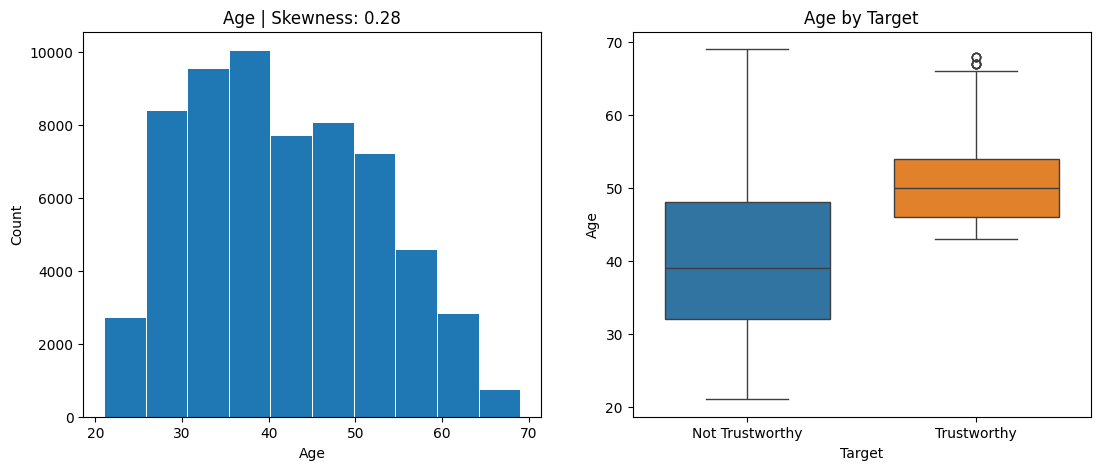

In [ ]:
plot_numerical(df, "Age", "Target")

Here it seems quite symmetrical, while looking at the boxplots it is interesting that only customers aged 42 and over appear to be more reliable.
From these first two variables alone we are already starting to get a general idea: customers over 42 and with an annual income of 150,000 tend to be categorized as more reliable.

This is a significant finding that could have several implications because we may be in a situation where the sample is not representative of the general population. This could be a problem as the model will systematically classify younger customers as not trustworthy, and this would introduce an age bias.

Although the dataset is of fair size, this does not necessarily imply that the sample is representative. We also do not exclude a situation of sampling errors in the data collected (3/4 of the dataset contained duplicates).

Possible solutions:

- It may be appropriate to collect more information regarding customers, as the one available now are not enough to explain the variability of the Target.

- If due to the non-representativeness of the sample, we could just collect more data while being careful to be as representative as possible (we currently have no more data available).
  
- We could also be in a situation where the problem does not depend on representativeness, then the bank should balance risk with inclusiveness, i.e. review risk policies to ensure they are based on solid data and not bias.

We listed possible solutions, but now, since we have no information about it, we will proceed anyway considering all customers under the age of 42 as unreliable. Of course, one should take all this into account when drawing conclusions.

### Employed_days

As pointed out previously, we have already identified anomalous values for **Employed_days**.

Analyzing in more detail all the records that have **Income_type** equal to "pensioner", we see that they correspond to the number 365243.
It turns out to be the only positive value, so we can deduce that there are no unemployed and that number corresponds to being retired.
Let's take a random record to point this out, but the same goes for everyone else too.

In [ ]:
df.iloc[[3, 24]]

Gender Own_car Own_realty  Number_children  Annual_income Income_type  \
7    Female      No        Yes                0       283500.0   Pensioner   
160  Female      No        Yes                0       112500.0   Pensioner   

                   Education_title Family_status       Housing_type   Age  \
7                 Higher education     Separated  House / apartment  62.0   
160  Secondary / secondary special       Married  House / apartment  61.0   

     Employed_days Mobile_flag Work_phone_flag Phone_flag Email_flag  \
7         365243.0         Yes              No         No         No   
160       365243.0         Yes              No         No         No   

    Occupation_type  Number_family_members           Target  
7               NaN                    1.0  Not Trustworthy  
160             NaN                    2.0  Not Trustworthy

We will treat this variable in the folliwing way.

First of all, since the variable is expressed in days, let's convert it into years to make it more intuitive.

In [ ]:
years = df["Employed_days"]/365*(-1)

Note that we have multiplied by (-1) so the division into bins will be more intuitive, otherwise the years would be in negative values.

We cannot keep the value 365243, because too large values ​​would alter the conclusions of the model and we cannot convert it so that it becomes how many days he has been retired, because that data is not available. Since we want to preserve the original nature of the dataset as much as possible, we will modify the variable in such a way to be able to include how long a customer has been retired together with the days passed since hiring.

To accomplish this, we will use a technique called binning, which consists in dividing a continuous range of values ​​into discrete intervals, i.e. we will transform the continuous numeric variable **Employed_days** into a categorical variable.

We will create a list where all values ​​<= 0 correspond to "pensioners", from 0 to 1 years they are classified as "junior", between 2 and 4 years as "medior" i.e. with medium experience, between 5 and 9 years as "senior" and finally all those with more than 10 years of experience in the same company are classified as "lead".

By doing this we could lose some information, because it could be that people who have decades of experience but have recently changed jobs in the same position but in another company, will be classified as "junior".

In [ ]:
cond_list = [years<=0, years<2, years<=4, years<10, years>=10 ]
choice_list = ["Pensioner", "Junior", "Medior", "Senior", "Lead"]

df["Employement"] = np.select(cond_list, choice_list)

Let's look at how our new variable looks.

In [ ]:
df["Employement"].value_counts()

Employement
Senior       20564
Junior       12831
Medior       12222
Lead         12138
Pensioner     4163
Name: count, dtype: int64

Since we created a new variable, let's remove the old one.

In [ ]:
df = df.drop("Employed_days", axis=1)

Let's look at the graphs.

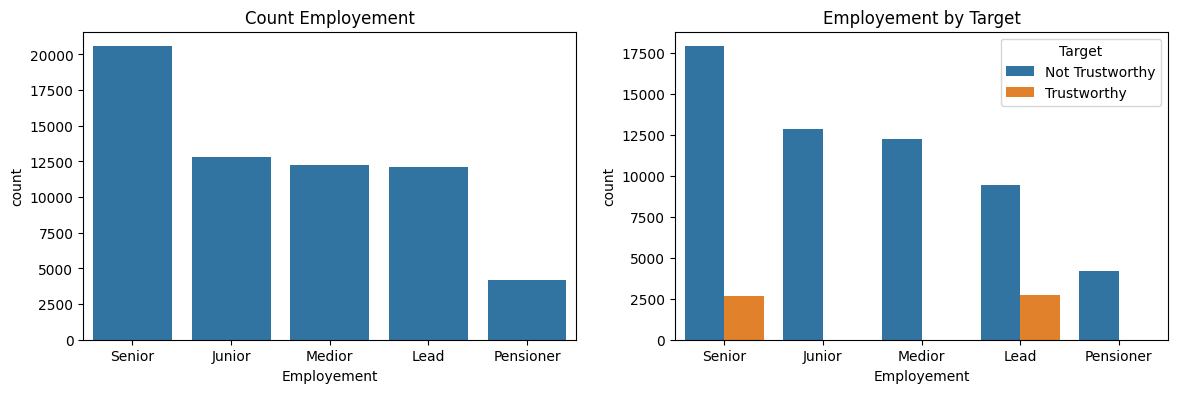

In [ ]:
plot_categorical(df, "Employement", "Target")

In [ ]:
pd.crosstab(df["Employement"], df["Target"]).T

Employement      Junior  Lead  Medior  Pensioner  Senior
Target                                                  
Not Trustworthy   12831  9418   12222       4163   17874
Trustworthy           0  2720       0          0    2690

Interestingly, after applying binning, this trend is immediate, where pensioners and those with little experience or who have just been hired by the company tend to be categorized as "Not Trustworthy".

Besides, in this case, as underlined in the **Age** part, we are in a case of work position bias.

The fact that only "lead" and "senior" categories have customers classified as trustworthy suggests a strong position-based bias.

This implies that only the highest level employees (lead and senior) are considered reliable, while all other categories (junior, medior and pensioner) are automatically considered unreliable.

This introduces unjustified discrimination based on professional role. Automatically excluding juniors, mediors and pensioners from being trusted can lead to a significant loss of information.

The possible solutions are the same as those presented for the **Age** variable.

We have not noticed any anomalous values ​​regarding age, but now that we have categorized the **Employement** variable let's see if there are anomalous values ​​between the various **Employement** modalities.

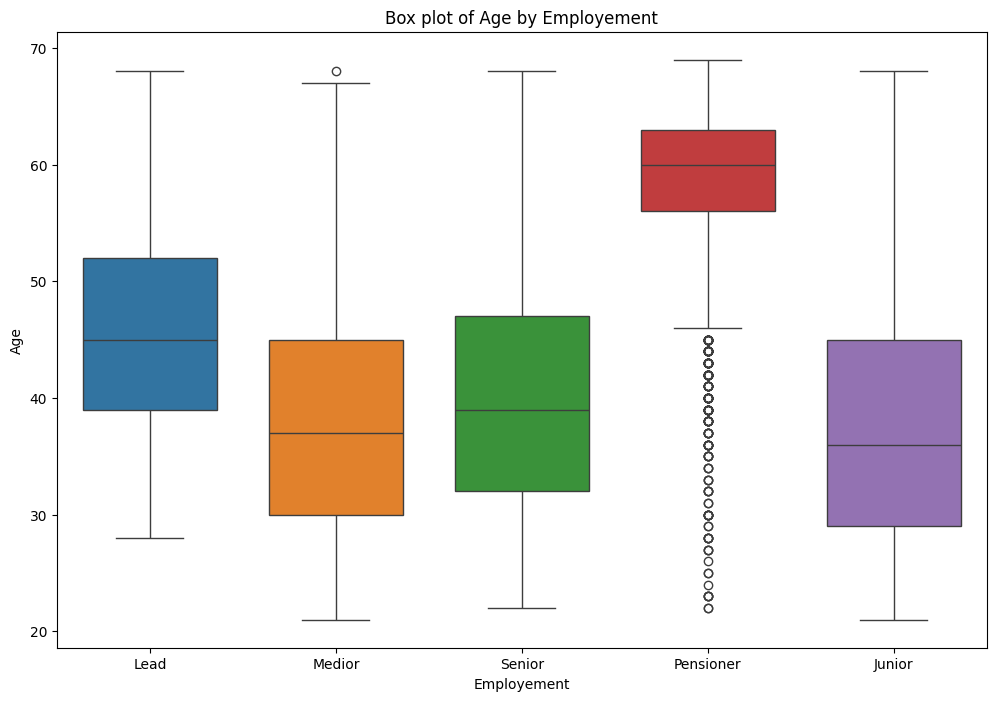

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(df, x="Employement", hue="Employement", y="Age", gap=.1)
plt.title("Box plot of Age by Employement")
plt.show()

There are customers that are too young to be considered in retirement age, but it must be considered that in some countries the retirement age starts from 50 for females and 60 for males.

Let's count how many pensioners are under the age of 50.

In [ ]:
n_pensioner_age_below = Counter(df["Income_type"].str.contains("Pensioner") & (df["Age"]<50))[1]

print(f"The number of pensioners aged below the accepted threshold of 50 years is {n_pensioner_age_below}")


The number of pensioners aged below the accepted threshold of 50 years is 320


We will use 50 as the minimum acceptable value. So now we are going to impute these incorrect values ​​with the median value of the age of pensioners.

In [ ]:
age_median = df["Age"][df["Age"]>50].median()
df["Age"] = np.where((df["Income_type"].str.contains("Pensioner")) & (df["Age"]<50), age_median, df["Age"])

Let's look at how the graph changes.

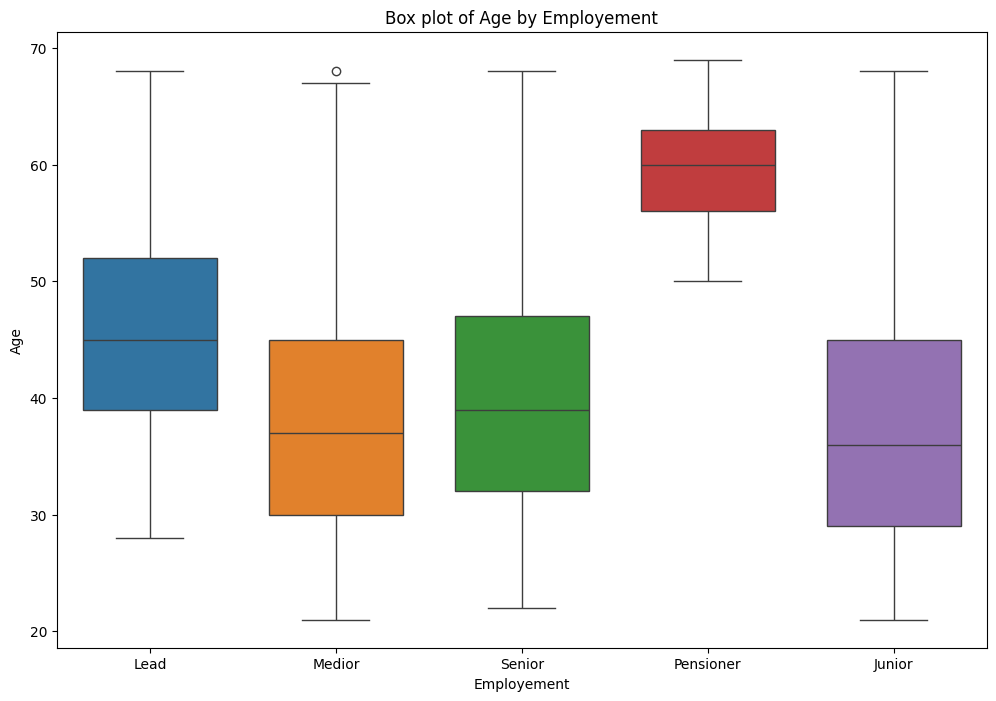

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(df, x="Employement", hue="Employement", y="Age", gap=.1)
plt.title("Box plot of Age by Employement")
plt.show()

As we can see, the various categories are quite consistent with the years of experience.

### Number_children

Let's look at how many children are distributed.

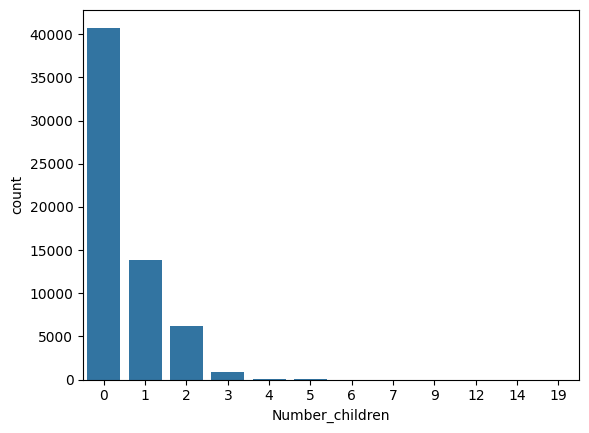

In [ ]:
sns.countplot(df, x="Number_children");

We immediately notice that after the second child there is a notable drop in class frequencies.

In [ ]:
df["Number_children"].value_counts().sort_index()

Number_children
0     40780
1     13901
2      6262
3       863
4        82
5        23
6         2
7         1
9         1
12        1
14        1
19        1
Name: count, dtype: int64

We opt to aggregate the less frequent classes, i.e. all those >=3, into a single mode which we will call ">=3". So basically we have turned a numeric variable into a categorical one.
By aggregating less frequent classes, a more stable and reliable evaluation of the model performance can be obtained.

In [ ]:
df.loc[df["Number_children"] >=3, "Number_children"] = ">=3"

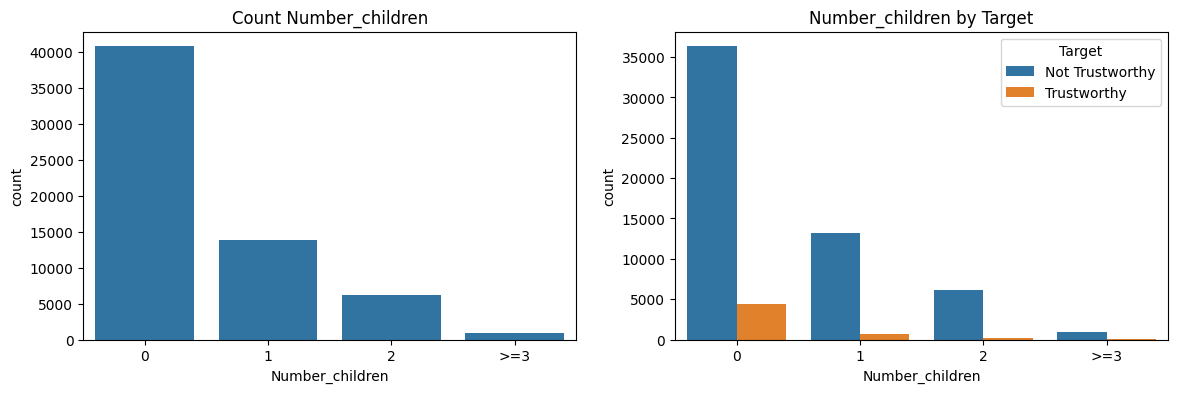

In [ ]:
plot_categorical(df, "Number_children", "Target")

In [ ]:
df["Number_children"] = df["Number_children"].map(str) # converted to string in order to pass to the function cross_tabulation
cross_tabulation(df, "Number_children", "Target")

Frequency table of Number_children by Target

Number_children      0     0(%)      1     1(%)     2     2(%)  >=3   >=3(%)
Target                                                                      
Not Trustworthy  36314  (89.0%)  13160  (94.7%)  6092  (97.3%)  942  (96.6%)
Trustworthy       4466  (11.0%)    741   (5.3%)   170   (2.7%)   33   (3.4%)


Those with no children tend to be classified as reliable in higher percentages.

### Number_family_members

Let's look at how the number of family members is distributed.

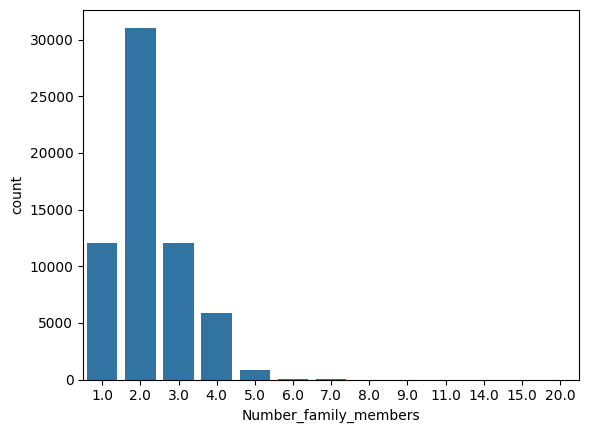

In [ ]:
sns.countplot(df, x="Number_family_members");

In [ ]:
df["Number_family_members"].value_counts().sort_index()

Number_family_members
1.0     12036
2.0     31052
3.0     12075
4.0      5838
5.0       809
6.0        79
7.0        22
8.0         2
9.0         1
11.0        1
14.0        1
15.0        1
20.0        1
Name: count, dtype: int64

We immediately notice a predominance of 2 members in the family followed by 1 and 3. Then also in this case we have a decrease in frequencies which we will treat as we did before for the variable **Number_children** for the same reasons.

In [ ]:
df.loc[df["Number_family_members"] >=3, "Number_family_members"] = ">=3"

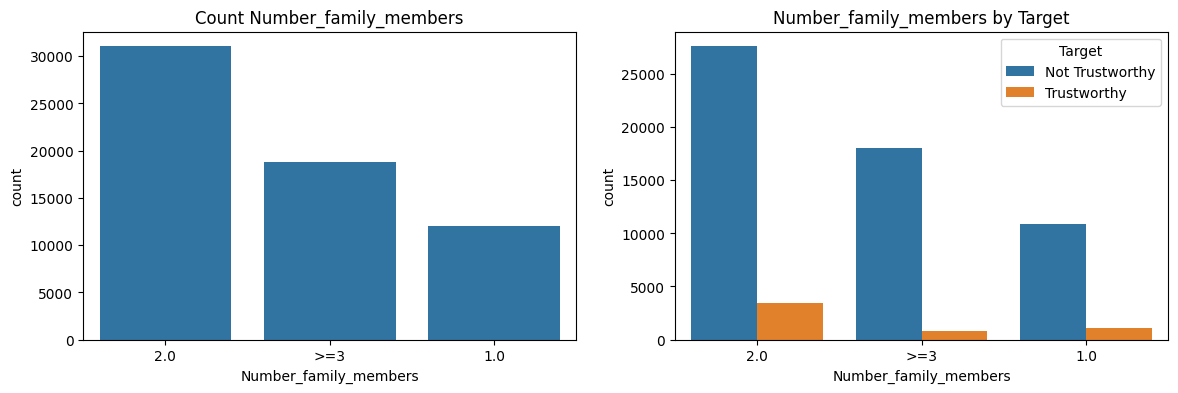

In [ ]:
plot_categorical(df, "Number_family_members", "Target")

In [ ]:
df["Number_family_members"] = df["Number_family_members"].map(str) # converted to string in order to pass to the function cross_tabulation
cross_tabulation(df, "Number_family_members", "Target")

Frequency table of Number_family_members by Target

Number_family_members    1.0   1.0(%)    2.0   2.0(%)    >=3   >=3(%)
Target                                                               
Not Trustworthy        10902  (90.6%)  27607  (88.9%)  17999  (95.6%)
Trustworthy             1134   (9.4%)   3445  (11.1%)    831   (4.4%)


In this case, families with 2 members are the ones that are most reliable in payments in terms of percentage majority.

## Categorical variables

We have transformed 3 numerical variables into categorical ones. Because of that, we update the two subdataframes.

In [ ]:
df_num =  df[["Annual_income", "Age"]]
df_cat = df.drop(columns=(df_num))

In [ ]:
df_cat.describe(include="all").T

count unique                            top   freq
Gender                 61918      2                         Female  38655
Own_car                61918      2                             No  37823
Own_realty             61918      2                            Yes  41115
Number_children        61918      4                              0  40780
Income_type            61918      5                        Working  36184
Education_title        61918      5  Secondary / secondary special  42168
Family_status          61918      5                        Married  41072
Housing_type           61918      6              House / apartment  54505
Mobile_flag            61918      1                            Yes  61918
Work_phone_flag        61918      2                             No  47392
Phone_flag             61918      2                             No  44358
Email_flag             61918      2                             No  55248
Occupation_type        48559     18                       Laborers  12852
Number_family_members  61918      3                            2.0  31052
Target                 61918      2                Not Trustworthy  56508
Employement            61918      5                         Senior  20564

Unlike numerical variables, in this case we cannot notice at first glance if there are categories with repeated or incorrect names. For this reason, we don't dwell too much into it. Let's look at the categorical variables in detail excluding those already treated previously.

### Gender

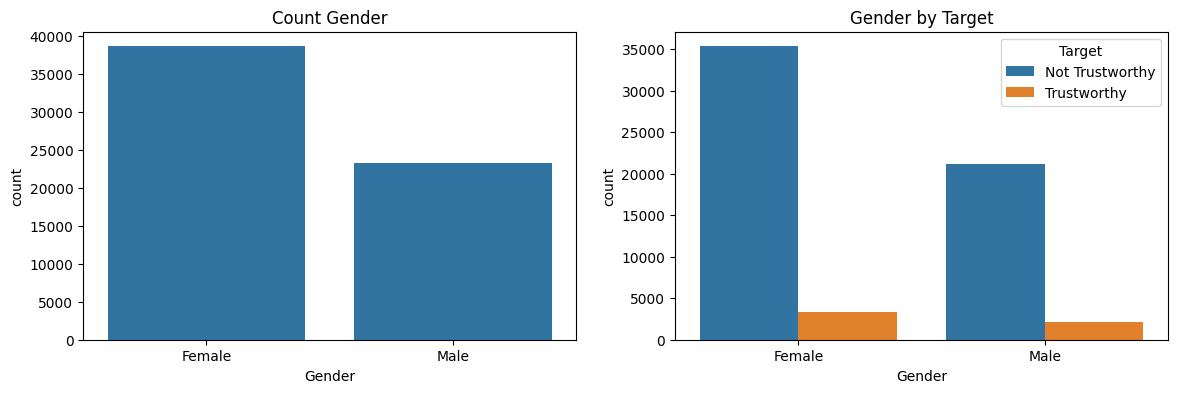

In [ ]:
plot_categorical(df, "Gender", "Target")

In [ ]:
cross_tabulation(df,"Gender","Target")

Frequency table of Gender by Target

Gender           Female Female(%)   Male  Male(%)
Target                                           
Not Trustworthy   35335   (91.4%)  21173  (91.0%)
Trustworthy        3320    (8.6%)   2090   (9.0%)


The female sex is most present compared to the male sex, and as regards trustworthiness it is slightly higher in males.

### Own_car

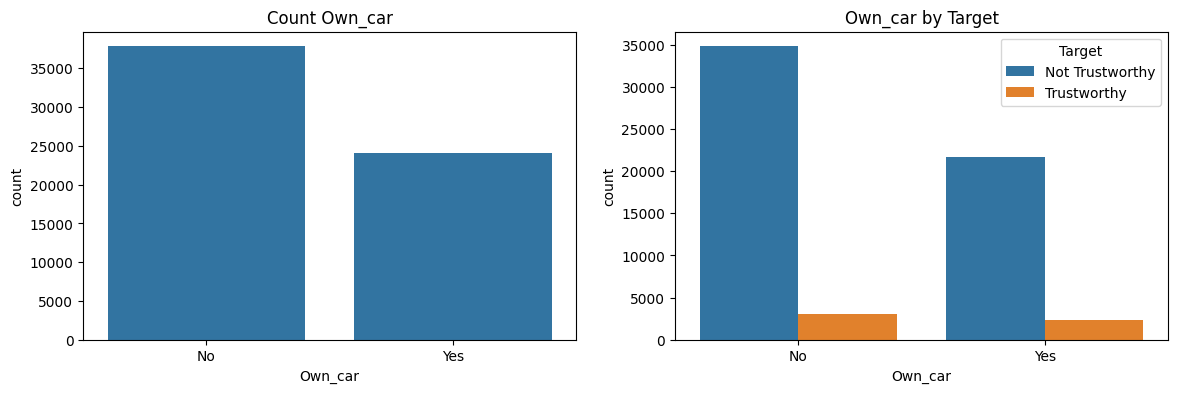

In [ ]:
plot_categorical(df, "Own_car", "Target")

In [ ]:
cross_tabulation(df, "Own_car", "Target")

Frequency table of Own_car by Target

Own_car             No    No(%)    Yes   Yes(%)
Target                                         
Not Trustworthy  34793  (92.0%)  21715  (90.1%)
Trustworthy       3030   (8.0%)   2380   (9.9%)


There are more customers who don't own a car than those who do, and those who own a car are more consistent with payments than those who don't.

### Own_realty

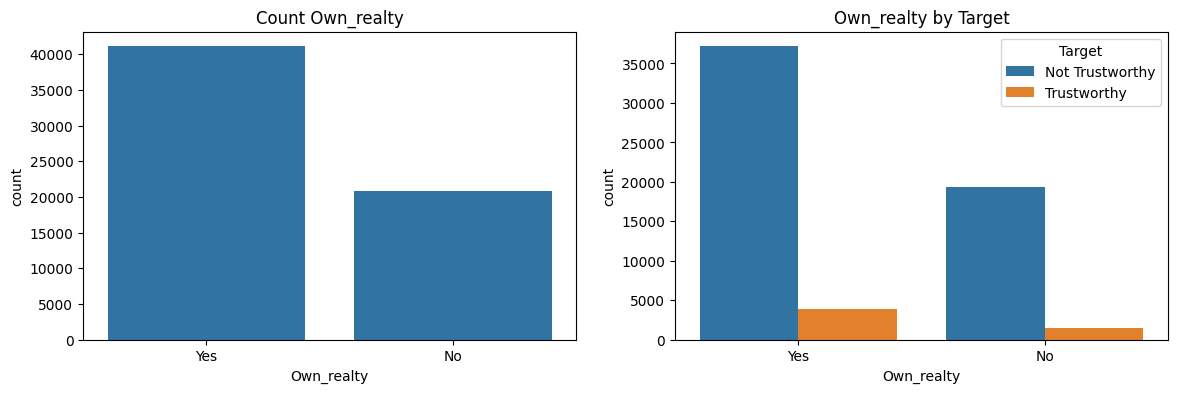

In [ ]:
plot_categorical(df, "Own_realty", "Target")

In [ ]:
cross_tabulation(df, "Own_realty", "Target")

Frequency table of Own_realty by Target

Own_realty          No    No(%)    Yes   Yes(%)
Target                                         
Not Trustworthy  19326  (92.9%)  37182  (90.4%)
Trustworthy       1477   (7.1%)   3933   (9.6%)


Customers of this bank are in absolute terms more likely to own property and those who does are more reliable in their payments.

### Income_type

It indicates the type of income. Let's see what types of income we have.

In [ ]:
df["Income_type"].value_counts()

Income_type
Working                 36184
Commercial associate    16356
State servant            5209
Pensioner                4163
Student                     6
Name: count, dtype: int64

We note "student" as a type of income. Let's analyze in detail whether age or other variables are congruent with the fact of being students.

In [ ]:
df_student_filt = df[df["Income_type"].str.contains("student")]
df_student_filt

Empty DataFrame
Columns: [Gender, Own_car, Own_realty, Number_children, Annual_income, Income_type, Education_title, Family_status, Housing_type, Age, Mobile_flag, Work_phone_flag, Phone_flag, Email_flag, Occupation_type, Number_family_members, Target, Employement]
Index: []

Looking in detail, given their age, other variables and the very low frequency with respect to the other modalities, they seem not to be students. We opt to incorporate them into the most frequent modality, namely "working" in the following way.

In [ ]:
df["Income_type"] = df["Income_type"].replace({"Student":"Working"})

Let's look at it graphically.

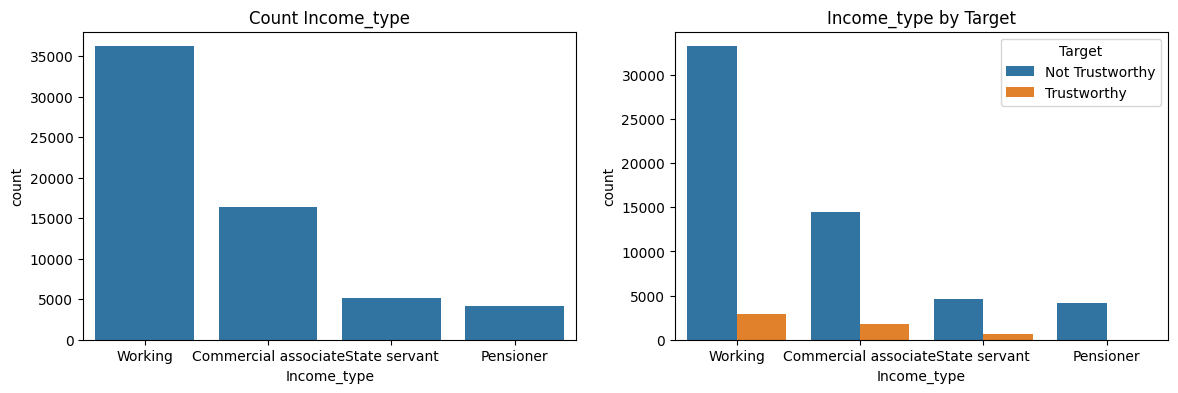

In [ ]:
plot_categorical(df, "Income_type", "Target")

In [ ]:
cross_tabulation(df, "Income_type", "Target")

Frequency table of Income_type by Target

Income_type      Commercial associate Commercial associate(%)  Pensioner  \
Target                                                                     
Not Trustworthy                 14525                 (88.8%)       4163   
Trustworthy                      1831                 (11.2%)          0   

Income_type     Pensioner(%)  State servant State servant(%)  Working  \
Target                                                                  
Not Trustworthy     (100.0%)           4582          (88.0%)    33238   
Trustworthy           (0.0%)            627          (12.0%)     2952   

Income_type     Working(%)  
Target                      
Not Trustworthy    (91.8%)  
Trustworthy         (8.2%)  


As we noted previously and as expected, those with a "pensioner" income type are classified as not reliable, while it seems the "state servant" income type is the most reliable in payments.

### Education_title

It indicates the level of education. Let's see what it looks like.

In [ ]:
df["Education_title"].value_counts()

Education_title
Secondary / secondary special    42168
Higher education                 16615
Incomplete higher                 2394
Lower secondary                    699
Academic degree                     42
Name: count, dtype: int64

We have 5 categories, but looking closer we have some that represent the same thing even if they are treated separately.

For example, "academic degree" and "higher education", where an academic degree is a qualification awarded to a student upon successful completion of a course of study in higher education, usually at a college or university (credits: Wikipedia).

The same goes for "incomplete higher" and "secondary/secondary special", since you have to complete a secondary school to access higher education, but if you don't complete it you still have a secondary degree.

We will regroup the categories in the following way:
"academic degree" together with "higher education", "incomplete higher" together with "secondary/secondary special", and "lower secondary".

In [ ]:
def map_education(education_title):

    if education_title in["Academic degree", "Higher education"]:
        return "Higher education"

    elif education_title in ["Incomplete higher","Secondary / secondary special"]:
        return "Secondary"

    else:
        return "Lower secondary"

#  Apply grouping rule
df["Education_title"] = df["Education_title"].apply(map_education)

Let's look at the graphs.

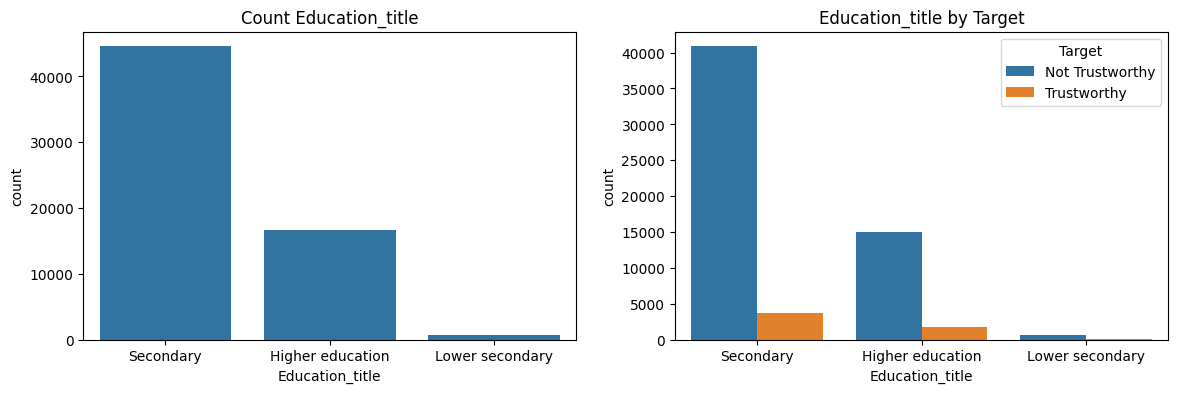

In [ ]:
plot_categorical(df, "Education_title", "Target")

Lower secondary is significantly less frequent than the other two modes. Previously, in a similar situation we would have combined it with another modality.

But in this case, to try to generalize better, we opt to leave it because not having completed secondary school could be linked to the fact of having jobs in positions with a lower wage and consequently less reliability.

In [ ]:
cross_tabulation(df, "Education_title", "Target")

Frequency table of Education_title by Target

Education_title  Higher education Higher education(%)  Lower secondary  \
Target                                                                   
Not Trustworthy             14955             (89.8%)              670   
Trustworthy                  1702             (10.2%)               29   

Education_title Lower secondary(%)  Secondary Secondary(%)  
Target                                                      
Not Trustworthy            (95.9%)      40883      (91.7%)  
Trustworthy                 (4.1%)       3679       (8.3%)  


In fact, as we note, those with a lower secondary education level tend to be less reliable than those with higher education, which is the most reliable class.

### Family_status

It represents the family status:

In [ ]:
df["Family_status"].value_counts()

Family_status
Married                 41072
Single / not married     9002
Civil marriage           5955
Separated                3926
Widow                    1963
Name: count, dtype: int64

We immediately notice that the majority of customers are married. Since marriage and civil marriage are the same, we opt to merge the two categories.

In [ ]:
df["Family_status"] = df["Family_status"].replace({"Civil marriage":"Married", "Single / not married":"Single"})

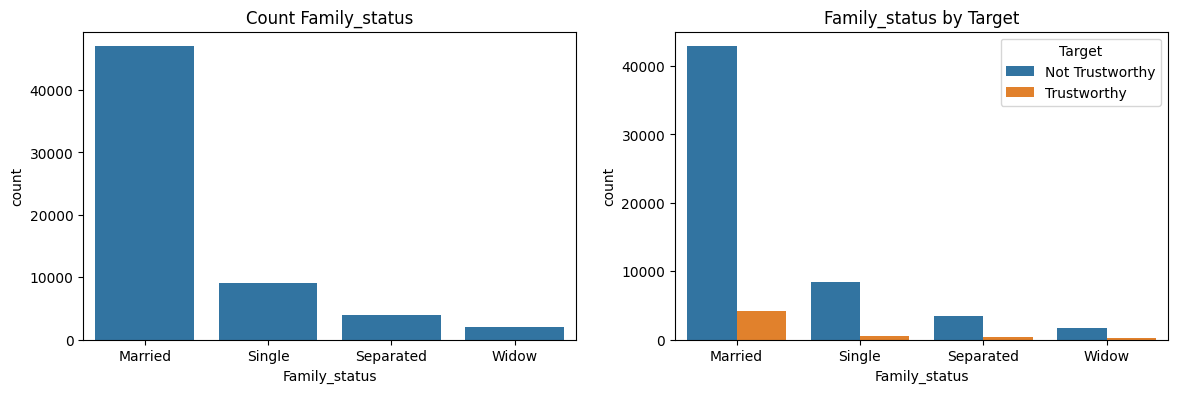

In [ ]:
plot_categorical(df, "Family_status", "Target")

In [ ]:
cross_tabulation(df, "Family_status", "Target")

Frequency table of Family_status by Target

Family_status    Married Married(%)  Separated Separated(%)  Single Single(%)  \
Target                                                                          
Not Trustworthy    42882    (91.2%)       3478      (88.6%)    8442   (93.8%)   
Trustworthy         4145     (8.8%)        448      (11.4%)     560    (6.2%)   

Family_status    Widow Widow(%)  
Target                           
Not Trustworthy   1706  (86.9%)  
Trustworthy        257  (13.1%)  


Single customers are those with the greatest propensity to be unreliable, while widow customers are the most reliable.

### Housing_type

It corresponds to the type of house.

In [ ]:
df["Housing_type"].value_counts()

Housing_type
House / apartment      54505
With parents            3220
Municipal apartment     2324
Rented apartment        1036
Office apartment         608
Co-op apartment          225
Name: count, dtype: int64

In this case, we have aggregated houses and apartments. There is no possibility of knowing who lives in a apartment or in a house.

 Since it is the most present category and the other modes are present with less frequency, we could aggregate them in a new other apartment category.
But this variable doesn't tell us much because then we have the variable **Own_realty** which already tells us whether they are owners or not.

If there had been the possibility of distinguishing the various types of property it might have made sense to leave it, but in this case the best solution is to remove the variable.

In [ ]:
df = df.drop("Housing_type", axis=1)

### Mobile_flag

It indicates if a customer owns a mobile number.

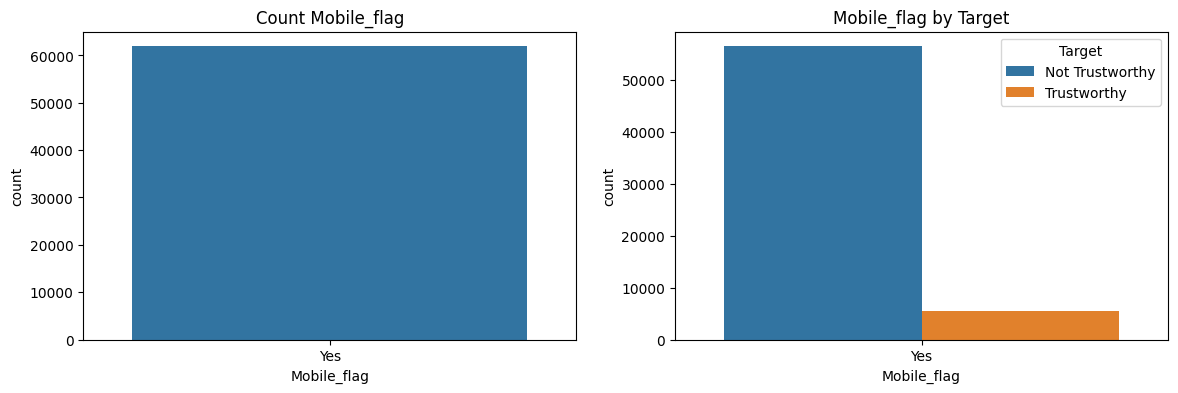

In [ ]:
plot_categorical(df, "Mobile_flag", "Target")

From the graph, it appears that all customers have a mobile number, so it is no longer a variable but a constant and the constants do not give us any information, so we opt to remove it.

In [ ]:
df = df.drop("Mobile_flag", axis=1)

### Work_phone_flag

It indicates if a customer owns a business telephone number.

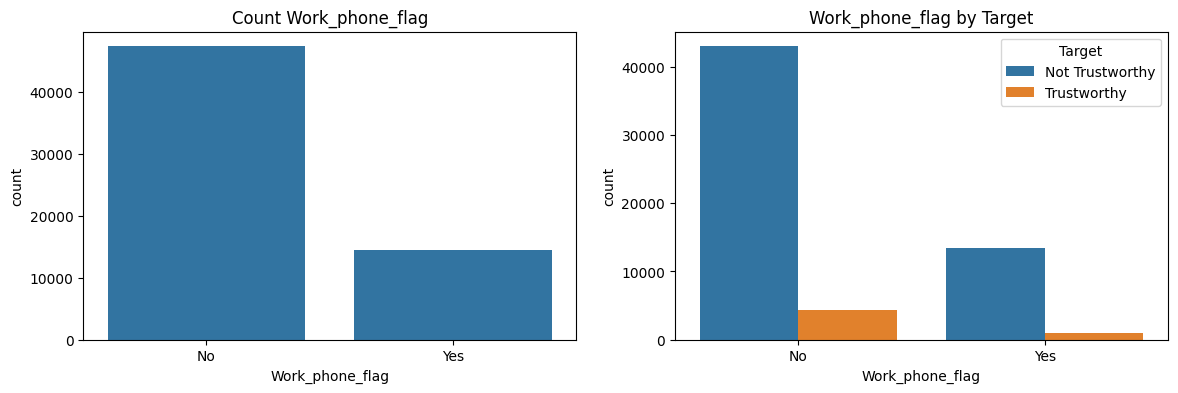

In [ ]:
plot_categorical(df, "Work_phone_flag", "Target")

In [ ]:
cross_tabulation(df, "Work_phone_flag", "Target")

Frequency table of Work_phone_flag by Target

Work_phone_flag     No    No(%)    Yes   Yes(%)
Target                                         
Not Trustworthy  43008  (90.7%)  13500  (92.9%)
Trustworthy       4384   (9.3%)   1026   (7.1%)


Most customers don't have a business phone number.

### Phone_flag

It indicates if a customer owns a telephone number. I think it refers to the landline.

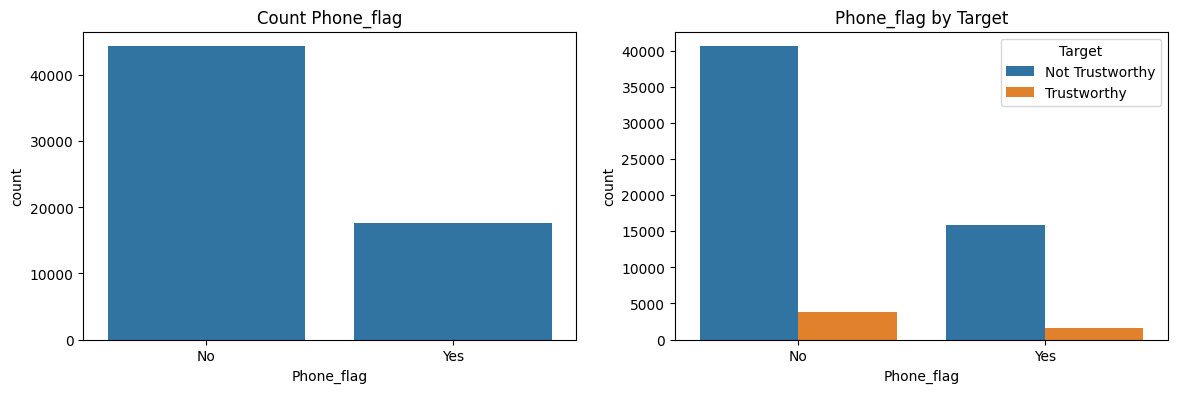

In [ ]:
plot_categorical(df, "Phone_flag", "Target")

In [ ]:
cross_tabulation(df, "Phone_flag", "Target")

Frequency table of Phone_flag by Target

Phone_flag          No    No(%)    Yes   Yes(%)
Target                                         
Not Trustworthy  40589  (91.5%)  15919  (90.7%)
Trustworthy       3769   (8.5%)   1641   (9.3%)


Most customers do not have a landline telephone.

### Email_flag

It indicates the presence if a customer owns an email address.

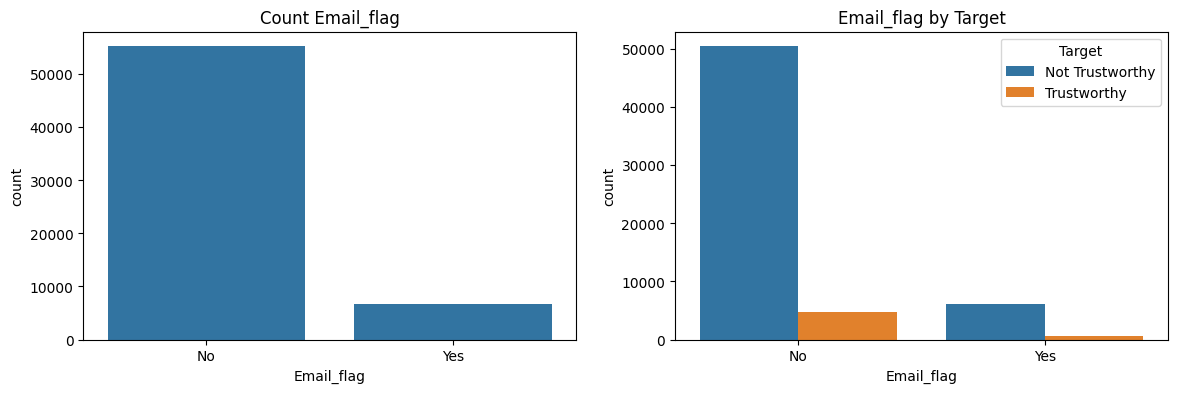

In [ ]:
plot_categorical(df, "Email_flag", "Target")

In [ ]:
cross_tabulation(df, "Email_flag", "Target")

Frequency table of Email_flag by Target

Email_flag          No    No(%)   Yes   Yes(%)
Target                                        
Not Trustworthy  50443  (91.3%)  6065  (90.9%)
Trustworthy       4805   (8.7%)   605   (9.1%)


The majority of customers do not have an email address. This seems strange, but doing some research, we found out that in some countries emails are not used much. It could also be that the information wasn't avaiable.

### Occupation_type

It indicates the employment.

In [ ]:
df["Occupation_type"].value_counts(dropna=False)

Occupation_type
NaN                      13359
Laborers                 12852
Sales staff               7028
Core staff                6350
Managers                  5146
Drivers                   4536
High skill tech staff     2611
Accountants               2355
Medicine staff            1934
Security staff            1374
Cooking staff             1365
Cleaning staff             959
Private service staff      586
Low-skill Laborers         443
Secretaries                317
Waiters/barmen staff       299
Realty agents              178
HR staff                   127
IT staff                    99
Name: count, dtype: int64

As previously noted, this variable has many null values ​​(13359). Rather than removing it directly, let's look for possible solutions.

Looking at the dataframe in more detail, the **Occupation_type** field is missing in all the **Income_type** equal to "pensioner" rows. So, one solution is adding **Occupation_type** = "pensioner" in all the rows where **Income_type** is "pensioner".
We are going to proceed in the following way.

In [ ]:
df.loc[df["Income_type"].str.contains("Pensioner"), "Occupation_type"] = "Pensioner"

In [ ]:
print(f"Now we have {df['Occupation_type'].isnull().sum()} NaN values")

Now we have 9196 NaN values


We have reduced the number of null values, but they are still present quite conspicuously. We cannot impute them all with the most present category since this would create bias conclusion.

Thus we opt to create a new category defined as "missing", which will indicate all customers who have not stated thier type of employment.

In [ ]:
df["Occupation_type"] = df["Occupation_type"].fillna("missing")

The variable will result in:

In [ ]:
df["Occupation_type"].value_counts(dropna=False)

Occupation_type
Laborers                 12852
missing                   9196
Sales staff               7028
Core staff                6350
Managers                  5146
Drivers                   4536
Pensioner                 4163
High skill tech staff     2611
Accountants               2355
Medicine staff            1934
Security staff            1374
Cooking staff             1365
Cleaning staff             959
Private service staff      586
Low-skill Laborers         443
Secretaries                317
Waiters/barmen staff       299
Realty agents              178
HR staff                   127
IT staff                    99
Name: count, dtype: int64

In [ ]:
print(f"Now we have {df['Occupation_type'].isnull().sum()} Nan values")

Now we have 0 Nan values


Now that we have imputed all the null values, ​​are we finished? Not really. we have 19 categories, most of which are present with little frequency.

The most present class is indicated with generic "laborers", which can refer to both the primary and secondary sectors as well as the "low-skill laborers" and "drivers" modalities. Instead, the various categories of the tertiary sector are clearly distinguished and many methods are present with little frequency.

So, the most representative method that came to mind for this variable is dividing the various categories into primary and secondary sectors together, tertiary, pensioners and missing.

In [ ]:
def map_job(job_title):
    if job_title in["Laborers", "Low-skill Laborers","Drivers"]:
        return "primary/secondary"
    elif job_title in ["Pensioner"]:
        return "pensioner"
    elif job_title in ["missing"]:
        return "missing"
    else:
        return "tertiary"

# Apply clustering rules
df["Occupation_type"] = df["Occupation_type"].apply(map_job)

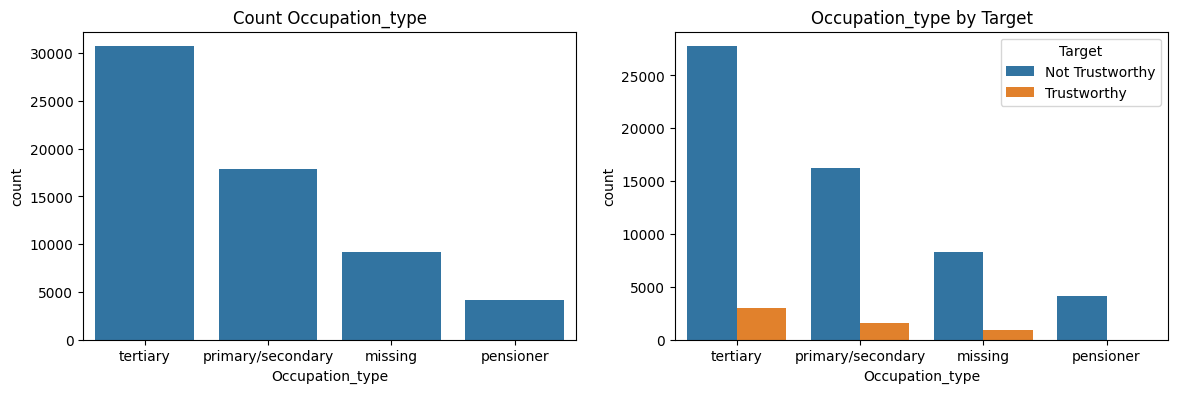

In [ ]:
plot_categorical(df, "Occupation_type", "Target")

In [ ]:
cross_tabulation(df, "Occupation_type", "Target")

Frequency table of Occupation_type by Target

Occupation_type  missing missing(%)  pensioner pensioner(%)  \
Target                                                        
Not Trustworthy     8324    (90.5%)       4163     (100.0%)   
Trustworthy          872     (9.5%)          0       (0.0%)   

Occupation_type  primary/secondary primary/secondary(%)  tertiary tertiary(%)  
Target                                                                         
Not Trustworthy              16267              (91.2%)     27754     (90.3%)  
Trustworthy                   1564               (8.8%)      2974      (9.7%)  


The tertiary sector is the most present and it also corresponds to a greater reliability for those who work in this sector.

### Target

Let's look at the distribution of the Target variable.

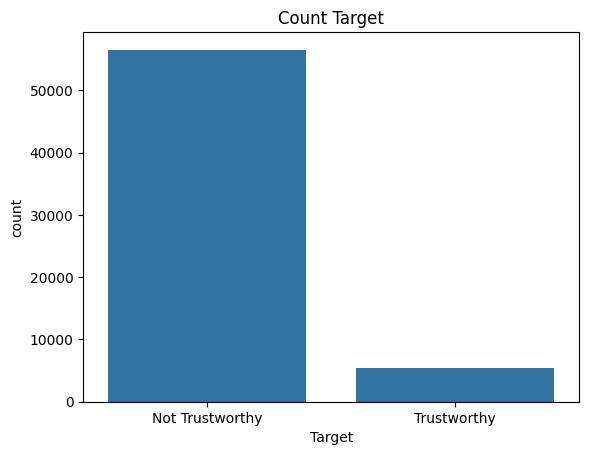

In [ ]:
plt.title("Count Target")
sns.countplot(data=df, x="Target")
plt.show()

In [ ]:
response_percentage_yes = round((Counter(df["Target"])["Trustworthy"])/len(df["Target"]), 5)*100

print(f"Percentage of customer classifed as Trustworthy: {response_percentage_yes:.3g}%")

Percentage of customer classifed as Trustworthy: 8.74%


Only the 8.74% of customers appears to be reliable according to the bank's standards. This denotes a Target skewed towards the "not trustworthy" class.

It would be interesting spending some words about how the majority of customers is labeled by the bank as "not trustworthy". As already noted, this is the case with customers who are less than 42 years old, who have less than 5 years of working experience and who are pensioner.

Let's try thinking about possible causes for this. For example, the customers can live in a city or country which is going through some socio-economic problems or the bank itself could be facing some problems, so, to be on the safe side, it has raised the threshold.
Another cause could be a labeling error of 0 and 1 from the person in charge of collecting data from customers. In this case, some customers labelled as "trustworthy" are classified as "non trustowrthy".

We can't know for sure the cause because we can't check with a domain expert, we won't take any more guesses and we will just analyze the data as they are.

## Correlation

We will calculate the correlation/strength of association of features for both categorical and continuous features by using:
- Pearson's R for continuous-continuous variables
- Correlation Ratio for categorical-continuous variables
- Cramer's V for categorical-categorical variables


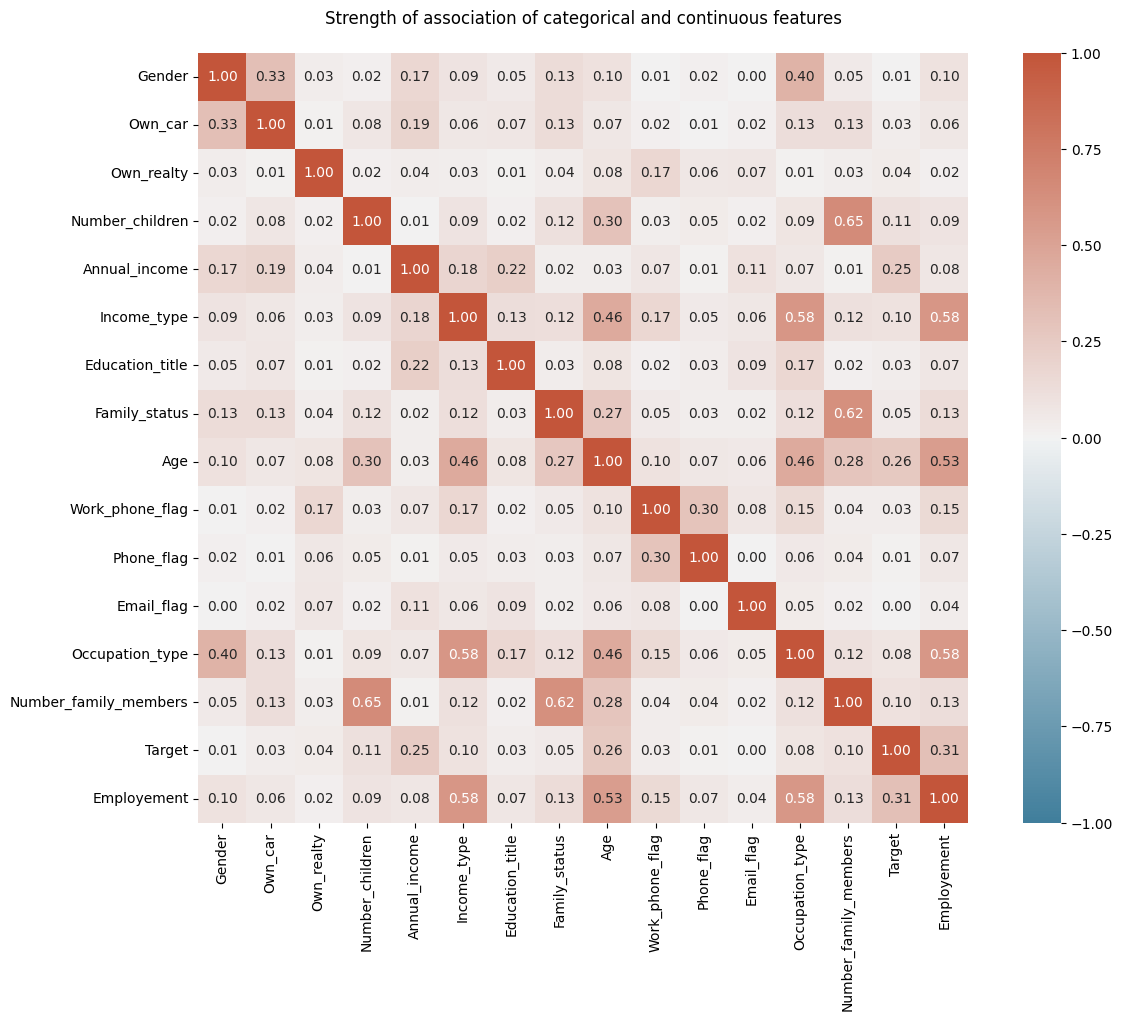

In [ ]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

c = nominal.associations(df, figsize=(14,10), cmap=cmap, title="Strength of association of categorical and continuous features\n")

Some pairs of variables are correlated. Later we will evaluate the possibility of reducing the size of the dataset through a feature selection.

## Preprocessor

The model requires only numerical values. Let's retransform all the categorical variables to make them suitable for interpretation. We will use **ColumnTransformer** which will be applied according to our needs to all the variables.

In [ ]:
# To make sure we don't make mistakes we manually convert the Target variable
size_mapping_target = {"Trustworthy":1, "Not Trustworthy":0}
df["Target"] = df["Target"].map(size_mapping_target)

In [ ]:
# division of features by type
numerical = ["Annual_income", "Age"]
categorical = ["Number_family_members","Number_children","Gender", "Own_car", "Own_realty", "Work_phone_flag","Phone_flag","Email_flag"]
categorical_nominal = ["Income_type", "Education_title","Family_status","Occupation_type","Employement"]

numerical_transformer = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")), # Median imputation
    ("num", StandardScaler()) # Standardization
])

categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Mode imputation
        ("bin", OrdinalEncoder())
])

categorical_ohe_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Mode imputation
        ("nom", OneHotEncoder())  # OneHotEncoder for nominal variables
])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical),
        ("ord", categorical_transformer, categorical),
        ("ohe", categorical_ohe_transformer, categorical_nominal)
    ])

# Predictive models exploration

We defined the various premises and performed the appropriate features engineering and clean out all possible duplicates/data entry errors. Now we are going to search for the best model to try to best classify the **Target** variable. We will test various model starting from simple logistic regression to more complex model such as XGBoost (eXtreme Gradient Boosting). We will try different approach through hyperparamter optimization to evaluate the one that best suits our problem.

Without forgetting that we are in the case of an unbalanced dataset, as seen in the exploratory part and to prevent the model from classifying everything in the majority class, we will pay particular attention to the metric we should use. In this case, accuracy and ROC AUC score may not be ideal because ROC AUC score can be sometimes misleading if there is a class imbalance. When the positive class is very small, ROC AUC can give a false impression of high quality metrics. The model correctly classifies most of the negative instances, and it may miss most of the positives, which is more important for the model performance.

Let's review again the 3 possible metrics to address this problem. As underlined in the introduction, it is not specified which way to proceed.

- Precision: if we want to focus to make sure that customers labeled as reliable are actually reliable.
- Recall: if we want to maximize profit opportunities and improve customer loyalty, so we don't lose reliable customers.
- F1-score: to balance the precision and recall.
  
To stay on a general approach, therefore we will focus on F1 score.


## Train and Test subsets

To ensure that our model adapts well to unknown data, we are going to divide our dataset into train set (75% of the data) and test set (25% of the data). The model will be trained only on train set, and the ability to generalize on the test set will be analyzed. We start by dividing features (X) and Target (y) and then creating the respective train and test sets.

In [ ]:
X = df.drop("Target", axis=1)
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

## Multiple models testing

Now, in order to find the best solution, we will test varius model together and check which best suits for our problem.
The following models were chosen above all for the management of the imbalance between the classes, because they all have the option to manage the weights and consequently it allows us to improve the imbalance by giving more weight to the minority class.

In [ ]:
# For XGBClassifier we manually calculate weight
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

# Models we want to test
models = {
    "Logistic Regression": LogisticRegression(solver="saga"),
    "Decision tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBClassifier": XGBClassifier()
}


Now that we have defined the various models, let's define the hyperparameters that we are going to optimize for each model, to look for the combination that best suits our problem.

We will not explore all the various combinations of the various possible hyperparameters, we will limit ourselves to those which obtain the necessary information, also because otherwise the computational cost becomes onerous.

Once the model has been chosen, an in-depth analysis of the various hyperparameters chosen will be carried out. Here are some explanation without going into too much detail about the choice of hyperparameters of the various models:

- **Random Forest** - max_depth and min_samples_leaf were set low as a preventative function against overfitting and to speed up calculations. For classification with few classes, min_samples_leaf=1 (default) is often the best choice.

- **Logistic Regression** - We opted for Elastic Net as regularization technique (it combines Lasso and Ridge), and can manage multicollinearity, do feature selection, reduce the risk of overfitting and underfitting to find an optimal balance between model complexity and predictive capacity.
  
- **Decision tree** - max_depth e min_samples_ were set low as a preventative function against overfitting and to speed up calculation. For classification with few classes, min_samples_leaf=1 (default) is often the best choice.

- **XGBClassifier** - It is the model among those chosen with more hyperparameters to be optimized, those deemed necessary for a preliminary phase were chosen. Below there is the hyperparameter grid.

In [ ]:
params_grid = {
    "Random Forest":{
    "Classifier__n_estimators": (50, 100, 150, 200, 300, 400, 500),
    "Classifier__criterion": ["gini", "entropy", "log_loss"],
    "Classifier__max_depth": [2,3,4,5,6,7],
    "Classifier__class_weight":["balanced",None,"balanced_subsample"]
    },

    "Logistic Regression":{
      "Classifier__C":[0.001, 0.01, 0.1, 1],
      "Classifier__penalty":["elasticnet"],
      "Classifier__l1_ratio":[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
      "Classifier__class_weight":[None,"balanced"]
    },

    "Decision tree":{
     "Classifier__criterion":["gini","entropy"],
     "Classifier__max_depth":[2,3,4,5,6,7,8,9,10],
     "Classifier__class_weight":["balanced",None]
    },

    "XGBClassifier":{
     "Classifier__n_estimators":(50, 100, 150, 200, 300, 400, 500),
     "Classifier__learning_rate":[0.001, 0.01, 0.1, 1],
     "Classifier__max_depth":[2,3,4,5,6,7,8],
     "Classifier__min_child_weight":[2,3,4,5,6,7,8],
     "Classifier__scale_pos_weight":[None,scale_pos_weight]
    }
}

Now, let's test all the models to get a general idea of ​​how they behave on our data.
We will display only "trustworthy" class and test set's metrics, with a focus on:

**Precison** - It is the percentage of the correct predictions made by the model for class "trustworthy". It measures the accuracy of the positive predictions.

**Recall** - It is the percentage of how many of the class "trustworthy" are correctly classified as "trustworthy". It measures the ability of the model to capture all relevant instances.

**F1-Score** - The harmonic mean of Precison and Recall, indicating the overall performance for class "trustworthy".

In [ ]:
model_score_f1 = test_models(models, params_grid, score="f1")

In [ ]:
models_test_f1 = pd.DataFrame(model_score_f1)
models_test_f1.round(3)

Model                                    Best Parameters  \
0  Logistic Regression  {'Classifier__penalty': 'elasticnet', 'Classif...   
1        Decision tree  {'Classifier__max_depth': 5, 'Classifier__crit...   
2        Random Forest  {'Classifier__n_estimators': 150, 'Classifier_...   
3        XGBClassifier  {'Classifier__scale_pos_weight': 10.4463889573...   

   Precision  Recall  F1 Score  
0      0.378   0.948     0.541  
1      0.672   0.998     0.803  
2      0.672   0.998     0.803  
3      0.672   0.998     0.803

Logistic Regression seems to be the model that performs worse than the others.
Decision Tree, Random Forest and XGBClassifier have the same metrics on test set and all have high recall but at the cost of losing some precision.

Other tests were conducted using SMOTENC, Oversampling and Undersampling. There were no significant differences to justify the use of resmpling techniques (they are not reported otherwise it would become too verbose notebook).
Looking at all the various metrics obtained, the choice that best balances results and interpretability is the Decision Tree. This will be the model that we will analyze in more detail.

# Model: Decision tree classifier

## Description

A Decision Tree is a simple representation for classifying examples. For this section, we assume that all of the input features have finite discrete domains, and there is a single Target feature called the "classification". Each element of the domain of the classification is called a class. A Decision Tree, or Classification Tree, is a tree in which each internal (non-leaf) node is labeled with an input feature. The arcs coming from a node labeled with an input feature are labeled with each of the possible values of the Target feature or the arc leads to a subordinate decision node on a different input feature. Each leaf of the tree is labeled with a class or a probability distribution over the classes, signifying that the data set has been classified by the tree into either a specific class, or into a particular probability distribution.

(credits: Wikipedia https://en.wikipedia.org/wiki/Decision_tree_learning)

Let's start by taking a step back by testing a model with all the default parameters.

## Baseline model

In [ ]:
base_line_pipeline  = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("Classifier", DecisionTreeClassifier())
    ]
)

In [ ]:
base_line_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num',
                                                                   StandardScaler())]),
                                                  ['Annual_income', 'Age']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('bin',
                                                                   OrdinalEncoder())]),
                                                  ['Number_family_members',
                                                   'Number_children', 'Gender',
                                                   'Own_car', 'Own_realty',
                                                   'Work_phone_flag',
                                                   'Phone_flag',
                                                   'Email_flag']),
                                                 ('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('nom',
                                                                   OneHotEncoder())]),
                                                  ['Income_type',
                                                   'Education_title',
                                                   'Family_status',
                                                   'Occupation_type',
                                                   'Employement'])])),
                ('Classifier', DecisionTreeClassifier())])

Let's try to understand a little about the information about our model, starting from max_depth (maximum depth) which is the parameter that specifies the maximum number of levels that the decision tree can have. In other words, it determines the maximum depth of the tree, i.e. the maximum number of nodes between the root and the furthest leaf.
Let's look at what it corresponds.

In [ ]:
base_line_pipeline["Classifier"].get_depth()

35

35 is a very high number. A tree that is too deep could fit the training data too well, causing overfitting. The tree graph is not shown because, being too deep, it would take too much time and nothing would be understood anyway.
Let's see how the model behaves on the train set.

In [ ]:
print(classification_report(y_train, base_line_pipeline.predict(X_train), target_names=["Not trustworthy", "Trustworthy"]))

                 precision    recall  f1-score   support

Not trustworthy       1.00      1.00      1.00     42381
    Trustworthy       1.00      0.99      0.99      4057

       accuracy                           1.00     46438
      macro avg       1.00      0.99      1.00     46438
   weighted avg       1.00      1.00      1.00     46438



We get practically perfect metrics. But this is not a good sign, in fact the opposite.
Let's look at how the model performs on the test set.

In [ ]:
print(classification_report(y_test, base_line_pipeline.predict(X_test), target_names=["Not trustworthy", "Trustworthy"]))

                 precision    recall  f1-score   support

Not trustworthy       0.97      0.97      0.97     14127
    Trustworthy       0.68      0.67      0.68      1353

       accuracy                           0.94     15480
      macro avg       0.82      0.82      0.82     15480
   weighted avg       0.94      0.94      0.94     15480



We observe a worsening of the metrics, a high difference between the train and test set which is too high.

As we see from the almost perfect metrics in the train set, we are clearly in an overfitting situation, which we want to avoid.
Overfitting tells us that the model is too complex and fits too well to the train data, and this leads to a poor ability to generalize the model on new data (test set), so any future change in the input data can lead to large changes in the model predictions. To overcome this problem we will apply pre and post pruning techniques (which we will delve into later).

No other considerations will be made on this model. Let's analyze the techniques mentioned above to manage overfitting.

## Pre pruning

### Description

Pre-pruning, also known as early stopping, consists of stopping the growth of the decision tree before it becomes too complex. During tree construction, criteria apply that determine when to stop splitting nodes.
Below there is the grid with all the hyperparameters that we will test to find the best combination.

### Hyperparamtes optimization and model fit

In [ ]:
param_grid_pre_pruning={
     "Classifier":[DecisionTreeClassifier()],
     "Classifier__criterion":["gini","entropy"],
     "Classifier__max_depth":[2, 3, 4, 5],
     "Classifier__min_samples_split":[2, 3, 4, 5],
     "Classifier__min_samples_leaf":[1, 2, 3, 4, 5],
     "Classifier__max_features": [None, "sqrt", "log2"],
     "Classifier__splitter": ["best", "random"],
     "Classifier__class_weight":[None, "balanced"]
    }


Description of hyperparameters:

**criterion**: Criterion for measuring the quality of a subdivision.
 - gini: Uses the Gini index as an impurity criterion.
 - entropy: Use the entropy of the information as an impurity criterion.

**max_depth**: The maximum depth of the tree. Limiting tree depth helps prevent overfitting.

**min_samples_split**: The minimum number of samples required to split an internal node.

**min_samples_leaf**: The minimum number of samples required to be in a node leaf.

**max_features**: The number of characteristics to be considered when looking for the best split.
 - None: It considers all characteristics.
 - sqrt: It takes the square root of the total number of features.
 - log2: It considers the base 2 logarithm of the total number of features.

**splitter**: The strategy used to choose the split at each node.
 - Best: It chooses the best division.
 - Random: It chooses the best split among a random subset of features.

**class_weight**: Weights associated with classes. If not specified, all classes have weight 1.
 - None: It does not apply any weight to classes.
 - Balanced: It adjusts the weights inversely proportional to the frequencies of the classes in the input dataset.

Now, using a random search, we will look for the best combination of hyperparameters.

In [ ]:
rs = RandomizedSearchCV(
    estimator=base_line_pipeline,
    param_distributions=param_grid_pre_pruning,
    scoring="f1", # reference metric
    cv=10,
    random_state=0,
    n_iter=30,
    n_jobs=-1,
)

pre_pruning_model = rs.fit(X_train, y_train)

In [ ]:
pre_pruning_model.best_params_

{'Classifier__splitter': 'best',
 'Classifier__min_samples_split': 5,
 'Classifier__min_samples_leaf': 2,
 'Classifier__max_features': None,
 'Classifier__max_depth': 4,
 'Classifier__criterion': 'gini',
 'Classifier__class_weight': None,
 'Classifier': DecisionTreeClassifier()}

Now we get a tree with a depth (max_depth) of 4. Now that the tree is not too deep let's see graphically how our algorithm behaves.

### Model features importance

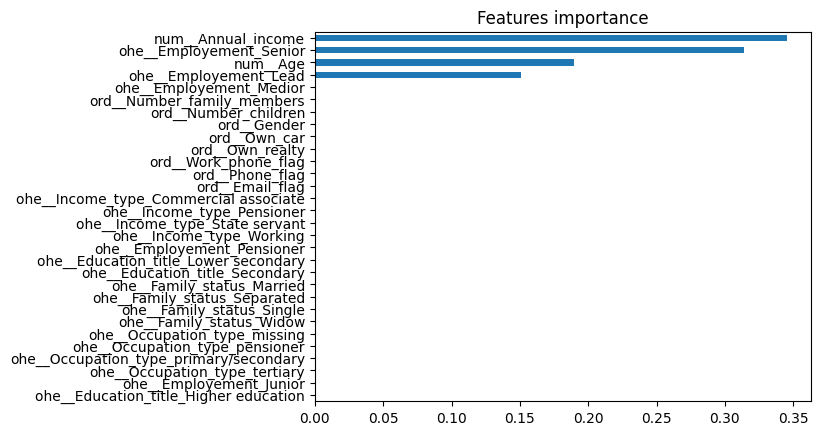

In [ ]:
feature_names = np.array(pre_pruning_model.best_estimator_["preprocessor"].get_feature_names_out())

importances = np.abs(pre_pruning_model.best_estimator_["Classifier"].feature_importances_)
pd.Series(importances, index=feature_names).sort_values().plot(kind="barh")
plt.title("Features importance")
plt.show()

Of all the variables available, only 4 are considered necessary to predict the output, all the others have a weight of 0 on the output. So our tree will be characterized by only these 4 variables. Below I will analyze and explain the structure of the tree in detail.

### Tree visualization

It consists of nodes representing decisions or tests on attributes, branches representing the outcome of these decisions, and leaf nodes representing final outcomes or predictions. Each internal node corresponds to a test on an attribute, each branch corresponds to the result of the test, and each leaf node corresponds to a class label. Leaf nodes represent the final decision or prediction (no further splits occur at these nodes).

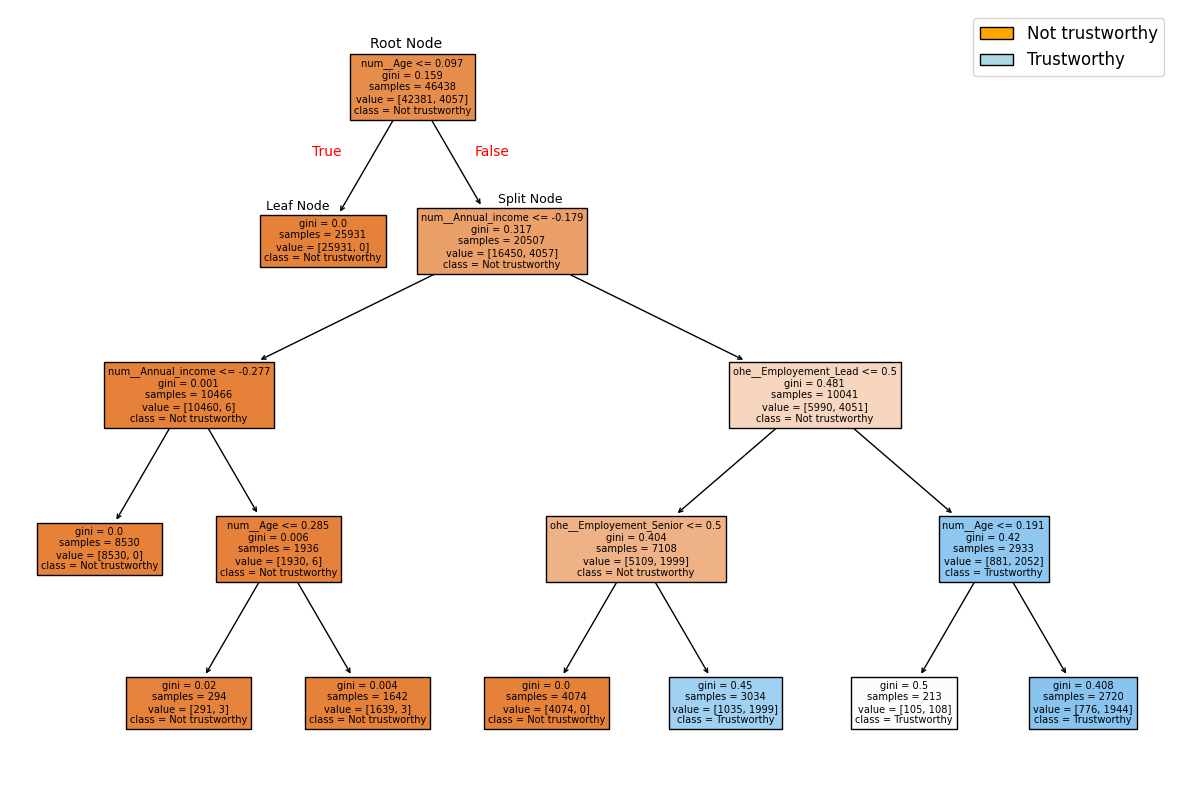

In [ ]:
plt.figure(figsize=(15, 10))

plot_tree(pre_pruning_model.best_estimator_["Classifier"], filled=True,
          feature_names=feature_names,
          class_names=["Not trustworthy", "Trustworthy"])

# graph text notations
plt.text(0.31,0.95, "Root Node", fontsize=10, color="black")

plt.text(0.22,0.74, "Leaf Node", fontsize=9, color="black")
plt.text(0.42,0.75, "Split Node", fontsize=9, color="black")

plt.text(0.26,0.81, "True", fontsize=10, color="red")
plt.text(0.40,0.81, "False", fontsize=10, color="red")



legend_elements = [Patch(facecolor="orange", edgecolor="black", label="Not trustworthy"),
                   Patch(facecolor="lightblue", edgecolor="black", label="Trustworthy")]

plt.legend(handles=legend_elements, loc="upper right", fontsize="large")

plt.show()

Remember that we have standardized values. Below are the retransformed values ​​to better understand the logic of the model.

In [ ]:
print("Age")
Standard_Scaler_Converter(df, "Age", [0.097, 0.191, 0.285])
print("------------------------------------------------")
print("Annual_income")
Standard_Scaler_Converter(df, "Annual_income", [-0.179,-0.277])

Age
Standardizied 0.097 value| True value: 42.6
Standardizied 0.191 value| True value: 43.6
Standardizied 0.285 value| True value: 44.6
------------------------------------------------
Annual_income
Standardizied -0.179 value| True value: 166208.4
Standardizied -0.277 value| True value: 157014.3


Let's start with the root node, there are 5 items that we will analyze below:

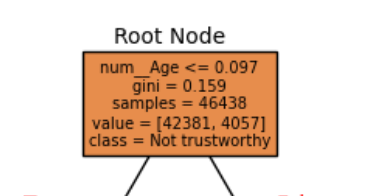

- **Age <= 0.097** - It asks if the customer's age is less than or equal to 0.097 standardized value and corresponds to 42 years.
  
- **gini = 0.159** - It is calculated by subtracting the sum of the squared probabilities of each class from one. A low Gini index indicates that the node is pure (i.e. it contains mostly instances of a single class), while a high Gini index indicates that the node is impure (i.e. it contains a mix of instances of various classes). In the first node, which corresponds to the entire train dataset, as we noticed during the EDA part we have an imbalance of the classes, therefore the gini index is low. The algorithm chooses the split that reduces the Gini index to the maximum, that is, it chooses the split that maximizes the purity of the resulting subsets.
  
- **samples = 46438** - Which corresponds to the total samples of the train set.
  
- **value = [42381, 4057]** - We have the first value, 42831, which corresponds to the most frequent class "Not trustworthy", and 4057, which corresponds to the minor class "Trustworthy".
  
- **class = "Not trustworthy"** - In case of root node and split node, it corresponds to the majority class (while for leaf node it is the predicted class).

Having explained the first node, let's analyze what happens if the condition **Age <= 42** is True or False:

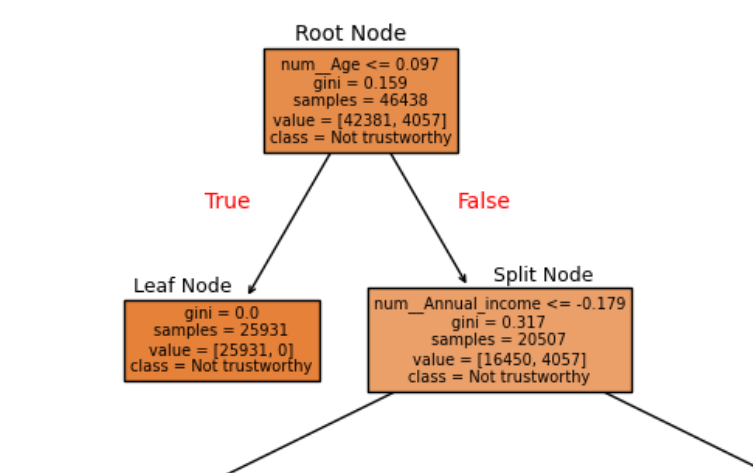

- **True** - With the True condition, i.e. if the customer is <=42 years old, a leaf is generated, Gini is 0, the samples are 25931 and they all correspond to the "Not trustworthy" class, which is also the predicted class. As said before, leaf nodes represent the final decision or prediction. No further splits occur at these nodes. Note that this pattern was already observed during EDA.

- **False**: These are all other customers aged over 42 and a new condition (split node) is created where it is asked whether Annual_income is less than or equal to -0.0179 (standardized value), which corresponds to 166208. Then it continues with the same logic explainded until there are only leaf nodes.

### Metrics

Now that we understand how our algorithm reasons and how it predicts classes, let's look in detail at all the metrics for both the train and the test set.

In [ ]:
print("Train subsets classification metrics\n")
print(classification_report(y_train,pre_pruning_model.predict(X_train), target_names=["Not trustworthy", "Trustworthy"], digits=3))

Train subsets classification metrics

                 precision    recall  f1-score   support

Not trustworthy      1.000     0.955     0.977     42381
    Trustworthy      0.679     0.999     0.808      4057

       accuracy                          0.959     46438
      macro avg      0.839     0.977     0.893     46438
   weighted avg      0.972     0.959     0.962     46438



On the data where we trained the model we obtain excellent metrics for the majority "Not trustworthy" class, while for the "Trustworthy" class we obtain discrete metrics. As we will note below, we are now not in a situation of overfitting as for the baseline model.

Let's now look at the test metrics, which are the most important for understanding how our algorithm behaves with never seen data.

In [ ]:
print("Test subsets classification metrics\n")
print(classification_report(y_test,pre_pruning_model.predict(X_test), target_names=["Not trustworthy", "Trustworthy"], digits=3))

Test subsets classification metrics

                 precision    recall  f1-score   support

Not trustworthy      1.000     0.953     0.976     14127
    Trustworthy      0.672     0.998     0.803      1353

       accuracy                          0.957     15480
      macro avg      0.836     0.976     0.890     15480
   weighted avg      0.971     0.957     0.961     15480



We observe the lack of overfitting, because the model we trained on train data behaves very similarly to the "unknown" test data. In the test data we observe a clear improvement in the precision, recall and f1-score metrics compared to the baseline model.

Let's analyze the confusion matrix on the test set to better understand how the model classifies the two classes.

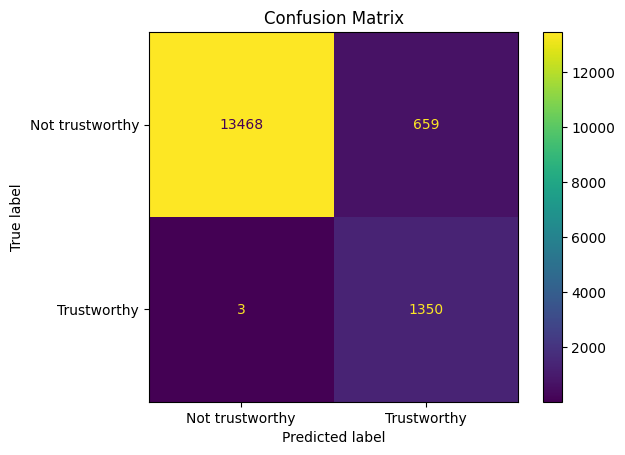

In [ ]:
ConfusionMatrixDisplay.from_estimator(pre_pruning_model, X_test, y_test, display_labels = ["Not trustworthy", "Trustworthy"])
plt.title("Confusion Matrix")
plt.show()

The recall for the "Trustworthy" class is very high (99.8%), which means that the model is very effective in identifying all the "Trustworthy" examples. In fact, as we notice we only have 3 false negatives and almost all customers considered "Trustworthy" have been correctly identified.

However, having an precision for the "Trustworthy" class of 67.2% leads to an increase in false positives. This indicates that the model incorrectly classifies "Not trustworthy" customers as "Trustworthy", in this case 659.

### Precision-Recall Curve

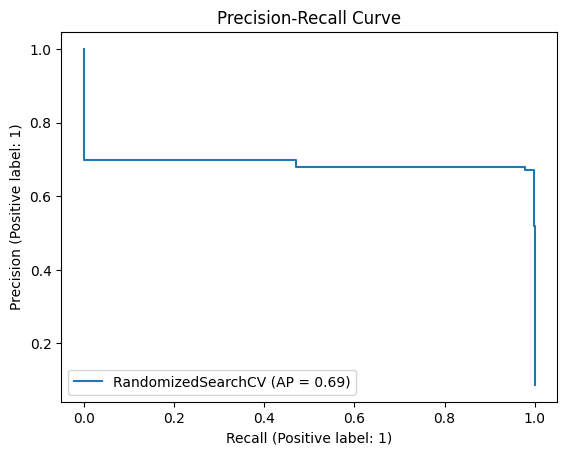

In [ ]:
PrecisionRecallDisplay.from_estimator(pre_pruning_model, X_test, y_test)
plt.title("Precision-Recall Curve")
plt.show()

An Average Precision (AP) of 69% indicates that, on average, the model has an accuracy of 69% when recall ranges from 0% to 100%. In this context where we have an unbalanced dataset, it indicates that the model has moderate performance.

## Post Pruning

Note: many of the cosiderations and logic are the same as for pre-pruning part, so they will not be explained from scratch as done before. Only the differences will be highlighted.

### Descrption

Post-pruning consists of building a decision tree without limitations on its growth (as done with the baseline model), and then reducing its complexity by cutting unnecessary branches, using just one hyperparameter ccp_alpha, which corresponds to the "complexity parameter alpha". It is used to balance the complexity of the tree against its accuracy during the pruning process.

### Hyperparamtes optimization and model fit

As we search space for our alpha hyperparameter, we will generate values ​​from 10^-4 to 10^0. In this range, alpha begins to significantly influence the complexity of the tree, pruning superfluous branches and improving generalization.

In [ ]:
param_grid_post_pruning = {
        "Classifier__ccp_alpha": np.linspace(0.0001, 1, num=1000)
    }

In [ ]:
rs = RandomizedSearchCV(
    estimator=base_line_pipeline,
    param_distributions=param_grid_post_pruning,
    scoring="f1", # reference metric
    random_state=0,
    n_jobs=-1
)

post_pruning_model = rs.fit(X_train, y_train)

In [ ]:
post_pruning_depth = post_pruning_model.best_estimator_["Classifier"].get_depth()
alpha = post_pruning_model.best_params_["Classifier__ccp_alpha"].round(5)

In [ ]:
print(f"Post pruned model has max depth: {post_pruning_depth} and alpha: {alpha}")

Post pruned model has max depth: 4 and alpha: 0.00911


So both the pre and post pruning will have the same depth of 4. Let's see if the importance of the feature changes between the two techniques.

### Model feature importance

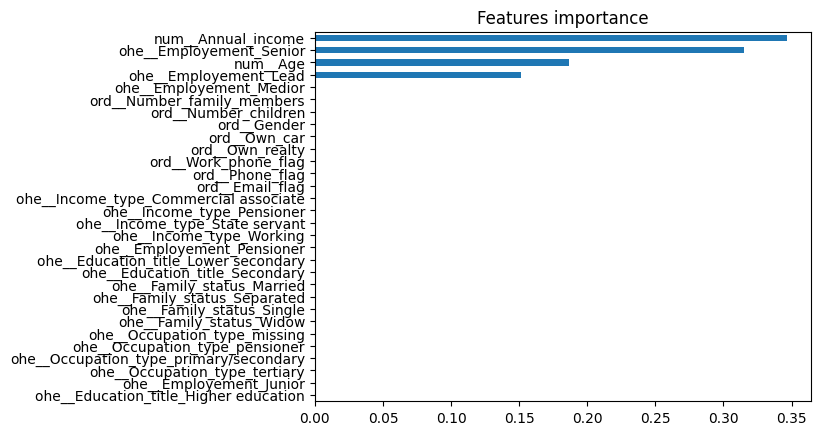

In [ ]:
importances = np.abs(post_pruning_model.best_estimator_["Classifier"].feature_importances_)
pd.Series(importances, index=feature_names).sort_values().plot(kind="barh")
plt.title("Features importance")
plt.show()

Both techniques consider only 4 variables necessary.

### Tree visualization

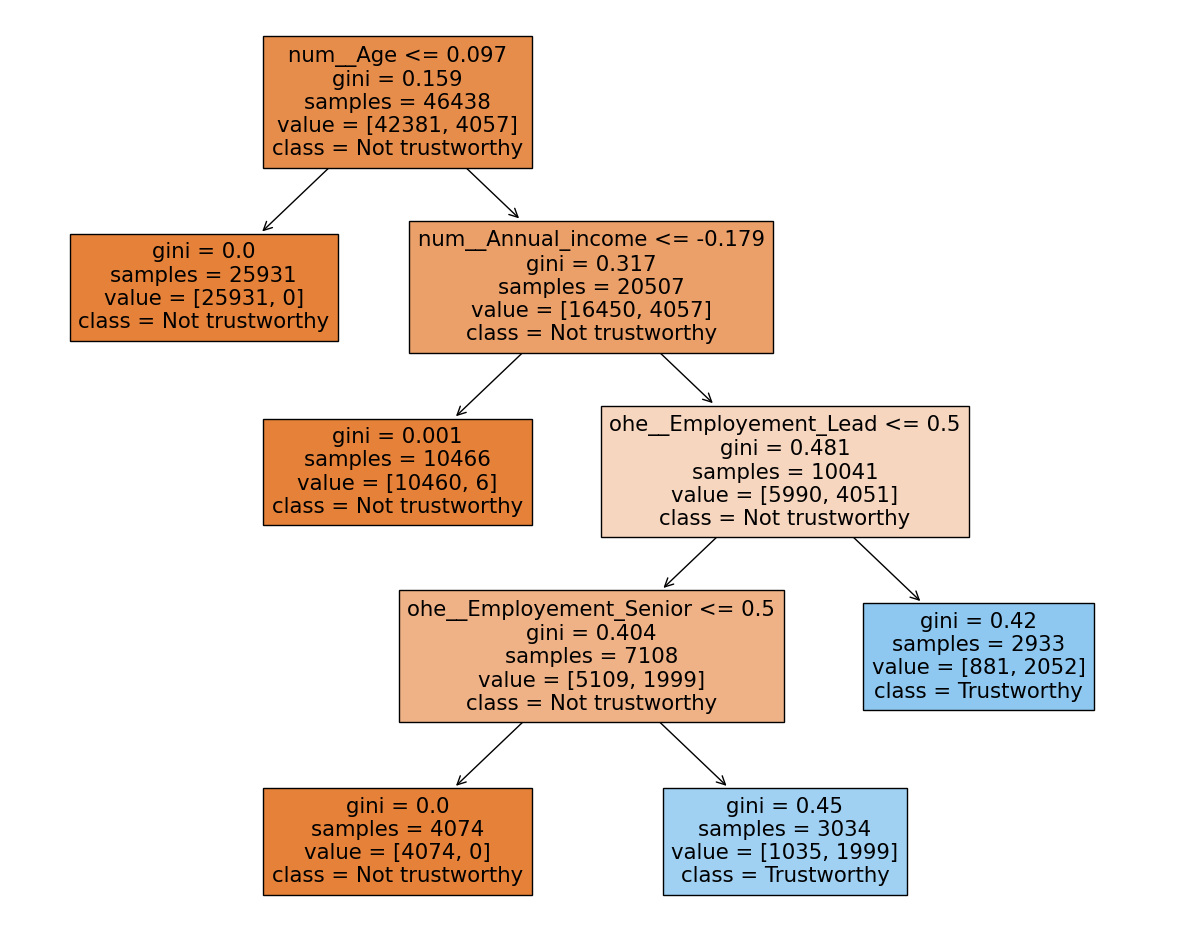

In [ ]:
plt.figure(figsize=(15, 12))

plot_tree(post_pruning_model.best_estimator_["Classifier"], filled=True,
          feature_names=feature_names,
          class_names=["Not trustworthy", "Trustworthy"])
plt.show()

In this case, we obtain a tree with the same depth but with less split node and leaf than the previous technique. The logic of tree choices is the same as explained during pre-pruning.

Let's observe how the metrics change for both the train and the test.

In [ ]:
print("Post pruning train subsets classification metrics\n")
print(classification_report(y_train,post_pruning_model.predict(X_train),target_names=["Not trustworthy", "Trustworthy"],digits=3))

Post pruning train subsets classification metrics

                 precision    recall  f1-score   support

Not trustworthy      1.000     0.955     0.977     42381
    Trustworthy      0.679     0.999     0.808      4057

       accuracy                          0.959     46438
      macro avg      0.839     0.977     0.893     46438
   weighted avg      0.972     0.959     0.962     46438



While for the test set we have:

In [ ]:
print("Post pruning test subsets classification metrics\n")
print(classification_report(y_test, post_pruning_model.predict(X_test), target_names=["Not trustworthy", "Trustworthy"],digits=3))

Post pruning test subsets classification metrics

                 precision    recall  f1-score   support

Not trustworthy      1.000     0.953     0.976     14127
    Trustworthy      0.672     0.998     0.803      1353

       accuracy                          0.957     15480
      macro avg      0.836     0.976     0.890     15480
   weighted avg      0.971     0.957     0.961     15480



Also, in this case there is no over fitting and the metrics are the same as the train set. Let's go directly to see the confusion matrix.

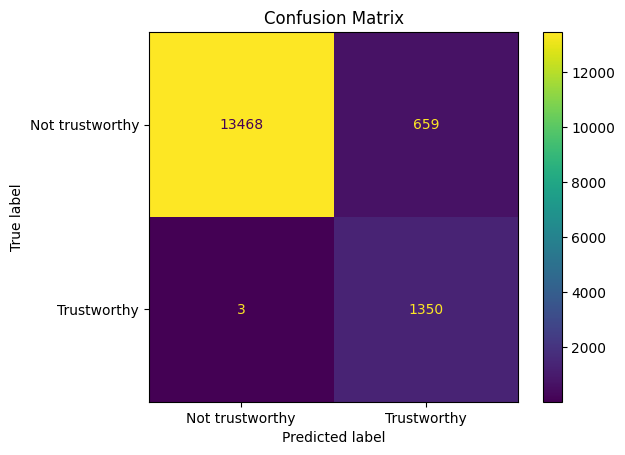

In [ ]:
ConfusionMatrixDisplay.from_estimator(post_pruning_model, X_test, y_test, display_labels = ["Not trustworthy", "Trustworthy"])
plt.title("Confusion Matrix")
plt.show()

We get the same metrics and thus the same confusion matrix, although with post pruning we have a simpler decision tree. The distribution of the data is such that significant divisions are few and very obvious, so both methods identify a relatively simple tree that represents the dataset well.

### Precision-Recall Curve

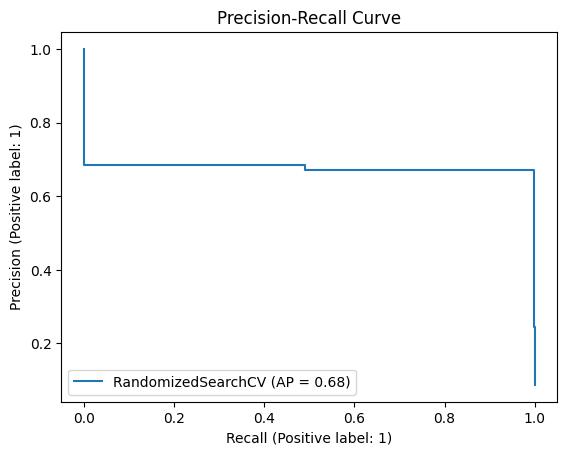

In [ ]:
PrecisionRecallDisplay.from_estimator(post_pruning_model, X_test, y_test)
plt.title("Precision-Recall Curve")
plt.show()

Unlike the pre-pruning model, we have an Average Precision (AP) a little lower than 1%.

# Local Model Interpretation and Conclusion

We have seen in detail how the tree chooses and classifies samples in general based on the various specifications provided.

Tests were also conducted where all the features that introduced bais were eliminated, but as we observed many of these were too significant to be removed and all the metrics obtained were remarkably low.

 Now, to expand and further understand how our model reasons, let's observe how it behaves in regard of a single customer, or the factors that lead to classifying it as "Not trustworthy" or "Trustworthy". We focus only on the post-pruned model because with a simpler tree we obtain the same metrics.

In [ ]:
# Define what needed to compute LimeTabularExplainer
X_transformed = post_pruning_model.best_estimator_["preprocessor"].transform(X_test) # Preprocessed X
model = post_pruning_model.best_estimator_["Classifier"]

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_transformed,
                                                   mode="classification",
                                                   class_names=["Not trustworthy", "Trustworthy"],
                                                   feature_names=feature_names)

exp = explainer.explain_instance(X_transformed[4],
                                 model.predict_proba,
                                 num_features=10)

# Note that you may want to set your theme to light to see it properly.
exp.show_in_notebook(show_table=True)

As can be noted, through lime we obtain a detailed vision of features and probabilities of a specific customer. This can be done with all the rows of the dataset, but for simplicity we limit ourselves to analyze just one client.

Let's analyze in detail, starting from the left side, the probabilities of the class predicted from the model. In this case, the probability of being classified as "Not trustworthy" is 34%, while the probability of being classified as "Trustworthy" is 66%. So, the class predicted from the model will be "Trustworthy", the one with the highest percentage.

In the central section we have which features contibute to the model prediction and how they do it. The trend toward the prediction of the "not trustworthy" and the "Trustworthy" class. As noted before, just 4 features have a big influence on prediction.

On the right side, we have the values of the features and we can see in an immediate way which features influence the output. If it is blu, it is "Not trustworthy", if it is orange, it is "Trustworthy". Remember that in the case of categorical variables, 0 corresponds to No and 1 to Yes.

Let's see what the two standardized values ​​of age and annual income correspond to:

In [ ]:
Standard_Scaler_Converter(df,"Age",[0.80])
Standard_Scaler_Converter(df,"Annual_income",[0.21])

Standardizied 0.8 value| True value: 50.0
Standardizied 0.21 value| True value: 202703.1


Therefore a customer who has a more solid work position (i.e. lead position, >10 years in the same company), who has more economic stability due to a high annual income of 202703, then the customer will be classified as "Trustworthy".